In [729]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype
from datetime import datetime

In [730]:
!pip install tensorflow

In [731]:
import tensorflow as tf

In [732]:
pd.options.mode.chained_assignment = None 

In [733]:
!pip install keras

In [734]:
!pip install scikeras

In [735]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Embedding, LSTM, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [736]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [737]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [738]:
!pip install shap
import shap

In [739]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [740]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [741]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [742]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [743]:
import sys
sys.path.append("./../../")
from gcp_env import PROJECT_ID, LOCATION

In [744]:
project_id = PROJECT_ID # Fill project id
bqclient = bigquery.Client(location=LOCATION, project=project_id)

# Tweets data

------

## Loading data

##### Loading users data to retriew label to add for each tweet

In [745]:
dataset_name = "twitbot_22_preprocessed_common_users_ids"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
users_table_id = project_id + "." + BQ_TABLE_USERS

In [746]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 5000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 5000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

##### Load tweets data 

In [747]:
dataset_name = "twitbot_22_preprocessed_common_users_ids"
tweets_table_name = "tweets"
BQ_TABLE_TWEETS = dataset_name + "." + tweets_table_name
tweets_table_id = project_id + "." + BQ_TABLE_TWEETS

In [748]:
# comma-separated string of user IDs from users dataframe
users_df0 = pd.DataFrame(users_df1).copy()
users_df0['id'] = users_df0['id'].astype(str)
user_ids = users_df0['id'].to_list()

# # SQL query to select records from the 'tweets' table
SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_TWEETS} WHERE CAST(author_id AS STRING) IN ({str(user_ids)[1:-1]})"""

tweets_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [749]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [750]:
len(tweets_df1)

426163

#### Append to tweets dataset author label (1/0, bot/human)

In [751]:
user_id_label_dict = users_df1.set_index('id')['label'].to_dict()
tweets_df1['author_label'] = tweets_df1['author_id'].map(user_id_label_dict)

In [752]:
tweets_df1

id            author_id  created_at  \
0        t871667974888988672             18456141  1496656814   
1       t1451246919590760454             50338306  1634839203   
2       t1464338171211227141             50338306  1637960400   
3       t1486051245441929219             50338306  1643137201   
4       t1449051082244739075            106526969  1634315674   
...                      ...                  ...         ...   
426158  t1494355678781374464  1298362221731274752  1645117132   
426159  t1496455096124772353  1442657001440489480  1645617672   
426160  t1490679777857970179  1468895392699846656  1644240729   
426161  t1490456171022626820  1477407428950036485  1644187417   
426162  t1493306549258829830  1486404323231899652  1644867000   

                                                                                                                                                                                                                                                                                                                         org_text  \
0                                                                                                                                                                                                                          10 things in tech you need to know today | https://t.co/iSQu4CN4rY via @BIUK_Tech #Tech #Morning #News   
1                                                                   Shannon Minter is a groundbreaking transgender civil rights attorney who argued successfully before the U.S. Supreme Court. He serves as the legal director of the National Center for Lesbian Rights (NCLR). https://t.co/UAum4Bu2Ce https://t.co/ZYmY080vj3   
2                                                                                                                                                         For the LGBTQ community, the annual end-of-the-year holiday season traditionally kicks off with costumed Halloween parties at clubs and homes.  https://t.co/NJ4CkorXuy   
3                                                                                                         André Leon Talley, an icon of fashion journalism, has died at the age of 73.\nBest known for his roles at Vogue as creative director and editor-at-large, which spanned from the 1980s to 2013. https://t.co/NQ7gZmfm21   
4                                                                                                       A month after Abbott issued a safety notice describing a defect that could cause some of its #COVID tests to return false positive results, the FDA has upgraded the issue into a Class I recall. https://t.co/OofNGRAVWg   
...                                                                                                                                                                                                                                                                                                                           ...   
426158              Looking for a minimalist logo design? Get your quote- https://t.co/TeykKS5TyJ https://t.co/WFRLSEZe7o #logo #icon #company #minimalist #simple #design #premium #unique #sundayvibes #AskFFT #SundayMorning #Haiti #Pecan #Gaskin #Wilt #Mahomes #Ahmed #Fnatic #Miami #NEWTOT #Grass https://t.co/fHd5dCKGUb   
426159            A little RESPECT goes a LONG WAY! We all want to get it, but we don't always give it. Do you feel that you are getting the respect that you deserve?\n#beginagainandwin #Givetoreceive #motivation #doyourpart #can'tcontrolpeople #itiswhatitis #yourfuture #blackmancan #hometraining https://t.co/xAxrkHgZas   
426160                                                                                       It feels good to Be lost In the right DIRECTION\n#Rentalcars #Cab #self #driving #longdrive #safe #mydriver #\n#newjourney #music #longdrive #cars #drivingschool #\n��https://t.co/xDWpE5Okqh\n��8886399949 https://t.co/KFbKVLGh8

### Filter dataset to have single newest tweet of each user

In [753]:
tweets_df1['created_at_datetime'] = pd.to_datetime(tweets_df1['created_at'], unit='s')

In [754]:
tweets_df1.sort_values(by='created_at_datetime', ascending=False, inplace=True)

In [755]:
tweets_df1 = tweets_df1.drop_duplicates(subset='author_id', keep='first')

In [756]:
org_tweet_df = pd.DataFrame(tweets_df1).copy()
tweets_df = pd.DataFrame(org_tweet_df).copy()

In [757]:
tweets_df.columns

Index(['id', 'author_id', 'created_at', 'org_text', 'text', 'source',
       'withheld', 'copyright_infringement', 'is_reply', 'geo_tagged',
       'latitude', 'longitude', 'conversation_id', 'reply_settings',
       'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'any_polls_attached', 'any_media_attached', 'possibly_sensitive',
       'has_referenced_tweets', 'media_attached', 'no_cashtags', 'no_mentions',
       'no_user_mentions', 'user_mentions', 'no_urls', 'contains_images',
       'contains_annotations', 'no_hashtags', 'hashtags',
       'context_annotations_domain_id', 'context_annotations_domain_name',
       'context_annotations_entity_id', 'context_annotations_entity_name',
       'author_label', 'created_at_datetime'],
      dtype='object')

In [758]:
len(tweets_df)

10000

In [759]:
tweets_df

id            author_id  created_at  \
95102   t1503346438364934149           4339019248  1647260696   
81194   t1502966161138278401  1365261130885603331  1647170031   
122908  t1502929969323913216            425696495  1647161402   
248143  t1502924166915411970             52678167  1647160019   
120472  t1502921292818771971  1282430868095565824  1647159333   
...                      ...                  ...         ...   
203915           t1384403391             26333561  1237933328   
125238           t1341212687             24856814  1237280149   
228063           t1337852185             24203450  1237229804   
414927             t86852782              6501462  1180707408   
165807             t21611251              1763471  1175973979   

                                                                                                                                                                                                                                                                                                                          org_text  \
95102                                           Saving money on your #AgileTDUSA ticket continues! With the Early Bird #discount, you can save up to $ 500 on your ticket for North America's greaTEST #agile #testing event. Offer available until May 1st! Get your ticket now: https://t.co/viX1WpYl4Y! https://t.co/uPIuhEjcia   
81194                                                         #AKATU\n\n1. Greetings Indeed!\n\nTo Observe So Many Souls Gathering In Love Even As The Energies Clash Around The Planet, Brings A Fresh Glow To My Crystal Heart! \n\nAllowing All To Unfold Is Knowing That Your Friends In High Places Are Holding You In Light!   
122908  Newquay minor injury unit (MIU), including x-ray, dental &amp; physio services,  is closed whilst undergoing essential building works. The unit will reopen on 14 March\n\nCall 111 to be directed to the right service &amp; alternative MIU @BBCCornwall  @piratefm @radionewquay @HeartCornwall https://t.co/W1j7gZ1TMD   
248143                                                                                                                                                                                RT @oundo_oundo: @ahmednasirlaw @makaumutua Am tired with you speaking the truth all the time. Election competition is between Uhuru Kenyat…   
120472                                                                                                                                                                                                                   To love something, then, is to name it after something so worthless it might be left untouched—and alive.   
...                                                                                                                                                                                                                                                                                                                            ...   
203915                                                                                                                                                                                     We're working on putting together a website to organize a grass roots movement to fight states that propose the NY style affiliate tax.   
125238                                                                                                                                                                                                                       Twittering in twitter, and learnt a new term today - "Twittering Under Influence ...... TUI" ........   
228063                                                                                                                                                                                                                                                           Just added some new companies to http://www.TheRecruit

# Data preparation

In [760]:
def drop_columns(df, columns):
    for column_name in columns:
        curr_df_all_cols = df.columns
        if column_name in curr_df_all_cols:
            df = df.drop([column_name], axis=1)
    return df

In [761]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

### Null and NaN statistics

In [762]:
for col_name in tweets_df:
    count1 = pd.isnull(tweets_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
author_id: 0
created_at: 0
org_text: 0
text: 0
source: 0
withheld: 0
copyright_infringement: 0
is_reply: 0
geo_tagged: 0
latitude: 9942
longitude: 9942
conversation_id: 0
reply_settings: 9526
retweet_count: 0
reply_count: 0
like_count: 0
quote_count: 0
any_polls_attached: 0
any_media_attached: 0
possibly_sensitive: 0
has_referenced_tweets: 0
media_attached: 0
no_cashtags: 0
no_mentions: 0
no_user_mentions: 0
user_mentions: 0
no_urls: 0
contains_images: 0
contains_annotations: 0
no_hashtags: 0
hashtags: 0
context_annotations_domain_id: 10000
context_annotations_domain_name: 10000
context_annotations_entity_id: 10000
context_annotations_entity_name: 10000
author_label: 0
created_at_datetime: 0


In [763]:
for col_name in tweets_df:
    count1 = pd.isnull(tweets_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
author_id: 0
created_at: 0
org_text: 0
text: 0
source: 0
withheld: 0
copyright_infringement: 0
is_reply: 0
geo_tagged: 0
latitude: 9942
longitude: 9942
conversation_id: 0
reply_settings: 9526
retweet_count: 0
reply_count: 0
like_count: 0
quote_count: 0
any_polls_attached: 0
any_media_attached: 0
possibly_sensitive: 0
has_referenced_tweets: 0
media_attached: 0
no_cashtags: 0
no_mentions: 0
no_user_mentions: 0
user_mentions: 0
no_urls: 0
contains_images: 0
contains_annotations: 0
no_hashtags: 0
hashtags: 0
context_annotations_domain_id: 10000
context_annotations_domain_name: 10000
context_annotations_entity_id: 10000
context_annotations_entity_name: 10000
author_label: 0
created_at_datetime: 0


### reply_settings

Twitter documentation for that field mantions that: If the field isn’t specified, it will default to everyone.

In [764]:
set(tweets_df.loc[tweets_df['reply_settings'].notna()]['reply_settings'])

{'everyone', 'mentionedUsers'}

In [765]:
set(tweets_df['reply_settings'])

{None, 'everyone', 'mentionedUsers'}

#### Replace not specified value / None with 'everyone'

In [766]:
tweets_df['reply_settings'].fillna('everyone', inplace=True)

#### Remove columns with most lacking value

In [767]:
most_nan_columns = ['context_annotations_domain_id',
                    'context_annotations_domain_name',
                    'context_annotations_entity_id',
                    'context_annotations_entity_name',
                    'latitude',
                    'longitude']
tweets_df = drop_columns(tweets_df, most_nan_columns)

## Encoding of non-numeric information which will be used by model

#### Encode boolean columns

In [768]:
boolean_columns  = ['withheld',
                    'copyright_infringement',
                    'is_reply',
                    'geo_tagged',
                    'any_polls_attached',
                    'any_media_attached',
                    'possibly_sensitive',
                    'has_referenced_tweets',
                    'media_attached',
                    'contains_images',
                    'contains_annotations']

In [769]:
# Remap the values of the dataframe
for col_name in boolean_columns:
    tweets_df[col_name] = tweets_df[col_name].map({True:1,False:0})
    
# Remap label values human/bot for 0/1
label_col = "author_label"
tweets_df[label_col] = tweets_df[label_col].map({"human":0,"bot":1})

#### Encode reply_settings categorical column

In [770]:
reply_settings_dict = {'everyone' : 0, 
                       'following' : 1, 
                       'mentionedUsers' : 2}

In [771]:
tweets_df['reply_settings'] = tweets_df['reply_settings'].map(reply_settings_dict)

In [772]:
set(tweets_df['reply_settings'])

{0, 2}

In [773]:
tweets_df

id            author_id  created_at  \
95102   t1503346438364934149           4339019248  1647260696   
81194   t1502966161138278401  1365261130885603331  1647170031   
122908  t1502929969323913216            425696495  1647161402   
248143  t1502924166915411970             52678167  1647160019   
120472  t1502921292818771971  1282430868095565824  1647159333   
...                      ...                  ...         ...   
203915           t1384403391             26333561  1237933328   
125238           t1341212687             24856814  1237280149   
228063           t1337852185             24203450  1237229804   
414927             t86852782              6501462  1180707408   
165807             t21611251              1763471  1175973979   

                                                                                                                                                                                                                                                                                                                          org_text  \
95102                                           Saving money on your #AgileTDUSA ticket continues! With the Early Bird #discount, you can save up to $ 500 on your ticket for North America's greaTEST #agile #testing event. Offer available until May 1st! Get your ticket now: https://t.co/viX1WpYl4Y! https://t.co/uPIuhEjcia   
81194                                                         #AKATU\n\n1. Greetings Indeed!\n\nTo Observe So Many Souls Gathering In Love Even As The Energies Clash Around The Planet, Brings A Fresh Glow To My Crystal Heart! \n\nAllowing All To Unfold Is Knowing That Your Friends In High Places Are Holding You In Light!   
122908  Newquay minor injury unit (MIU), including x-ray, dental &amp; physio services,  is closed whilst undergoing essential building works. The unit will reopen on 14 March\n\nCall 111 to be directed to the right service &amp; alternative MIU @BBCCornwall  @piratefm @radionewquay @HeartCornwall https://t.co/W1j7gZ1TMD   
248143                                                                                                                                                                                RT @oundo_oundo: @ahmednasirlaw @makaumutua Am tired with you speaking the truth all the time. Election competition is between Uhuru Kenyat…   
120472                                                                                                                                                                                                                   To love something, then, is to name it after something so worthless it might be left untouched—and alive.   
...                                                                                                                                                                                                                                                                                                                            ...   
203915                                                                                                                                                                                     We're working on putting together a website to organize a grass roots movement to fight states that propose the NY style affiliate tax.   
125238                                                                                                                                                                                                                       Twittering in twitter, and learnt a new term today - "Twittering Under Influence ...... TUI" ........   
228063                                                                                                                                                                                                                                                           Just added some new companies to http://www.TheRecruit

### Extract some information from dataframe to new columns

#### Tweet length

In [774]:
tweets_df['cleaned_tweet_len'] = tweets_df['text'].apply(len).astype(float)
tweets_df['org_tweet_len'] = tweets_df['org_text'].apply(len).astype(float)

#### Time of the date (in min, UTC)

In [775]:
def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

def get_time_in_minutes(unix_time):
    h = convert_unixtime_to_datetime(unix_time).hour
    m = convert_unixtime_to_datetime(unix_time).minute
    all_minutes = (h * 60) + m
    return all_minutes

In [776]:
tweets_df['time_of_creation'] = tweets_df.apply(lambda x:  get_time_in_minutes(x.created_at), axis=1).astype(float)

### Remove some leftover special characters

In [777]:
tweets_df['text'] = tweets_df['text'].str.replace('|', '', regex=False)

## Data split for training, validation and testing of tweets data based on users data split

In [778]:
train_tweets_data, test_tweets_data = train_test_split(tweets_df, test_size=0.30, random_state=25, shuffle=True)
test_tweets_data, val_tweets_data = train_test_split(test_tweets_data, test_size=0.5, random_state=25, shuffle=True)

In [779]:
train_tweets_data1 = pd.DataFrame(train_tweets_data).copy()
val_tweets_data1 = pd.DataFrame(val_tweets_data).copy()
test_tweets_data1 = pd.DataFrame(test_tweets_data).copy()

# Analysis

In [780]:
train_tweets_data

id            author_id  created_at  \
287350  t1454945290956460034  1305494024158052352  1635720963   
161095  t1498553623177048065  1288829286149808128  1646118000   
97883           t22653184913             17041877  1283292706   
37772   t1432941694572367873            896671255  1630474897   
333026  t1497243521509572610             30971806  1645805647   
...                      ...                  ...         ...   
3429    t1499778158530375689            258921288  1646409952   
320117  t1196153541376856064   725743093555679232  1574020202   
112123  t1498012521827086337  1227176080563474432  1645988991   
360121  t1455241895181832193             25898134  1635791679   
374514  t1170128330437332994  1026991231111294976  1567815308   

                                                                                                                                                                                                                                                                                                              org_text  \
287350                                                                                                                                                                RT @ibrahimsideals: Please RT/Share\n\n my link and donate whatever you can to this year’s charity week 2021!! \n\nMay Allah SWT accept it from…   
161095                                                                                                                                ✨Daily Comment Threads✨\n\n�� Follow us\n�� RT this so everyone can join\n�� Share your blog post link\n�� Engage with others\n�� Spread the love\n\nHave fun!��\n\n#writerslift   
97883                                                                                                                                                                       @EarthClassMail I believe I clearly stated that I'm willing to talk to you in public. And exactly who should I be talking to?  Who's "me"?   
37772                                                                                                                        "We're talking about freedoms, but I don't think people will appreciate the number of deaths to come, and we should be doing everything we can to prevent it".  \nhttps://t.co/oEObOaXMSC   
333026  Running outdoors is wonderful exercise and you get the benefits of being out in the fresh air. If you overdo it and have any sore joints and muscles, reach for your Gelzone® Wrap and experience comfortable, uniform compression and pain relief. #gelzone #gelzonewrap #compression https://t.co/moychZJjJh   
...                                                                                                                                                                                                                                                                                                                ...   
3429                                                                          @creditscoring @Equifax @Experian @AskTU @TransUnionUK Hi Greg, I am providing you with a link with addition information on how your credit score is calculated. https://t.co/23Se4ZD96w   If you have addition questions, Drop us a DM!   
320117                                                                                                                                                                                                                                     Happy Founders Day Omega Psi Phi Fraternity Inc.!!! https://t.co/nbiPJnCGWZ   
112123                                                                                                                                                                    RT @MikeShaugh: The Global Tapestry of Alternatives: Stories of Resilience, Existence, and Re-Existence https://t.co/8CJz9D49Oe #greenparty…   
360121                                                                                                   

In [781]:
train_tweets_data.columns

Index(['id', 'author_id', 'created_at', 'org_text', 'text', 'source',
       'withheld', 'copyright_infringement', 'is_reply', 'geo_tagged',
       'conversation_id', 'reply_settings', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'any_polls_attached', 'any_media_attached',
       'possibly_sensitive', 'has_referenced_tweets', 'media_attached',
       'no_cashtags', 'no_mentions', 'no_user_mentions', 'user_mentions',
       'no_urls', 'contains_images', 'contains_annotations', 'no_hashtags',
       'hashtags', 'author_label', 'created_at_datetime', 'cleaned_tweet_len',
       'org_tweet_len', 'time_of_creation'],
      dtype='object')

### Drop columns in dataframes where there are same value in whole column in training dataset

In [782]:
not_simple_numeric_col = ['id', 'author_id', 'created_at', 'org_text', 'text', 'source', 
                          'conversation_id',
                          'user_mentions', 'hashtags', 
                          'author_label', 
                          'created_at_datetime',]

In [783]:
same_data_columns = list(train_tweets_data.drop(not_simple_numeric_col, axis=1).columns[train_tweets_data.drop(not_simple_numeric_col, axis=1).apply(lambda x: x.nunique()) == 1])
same_data_columns

['withheld',
 'copyright_infringement',
 'reply_settings',
 'any_polls_attached',
 'media_attached',
 'contains_images']

In [784]:
# ['withheld',
#  'copyright_infringement',
#  'reply_settings',
#  'any_polls_attached',
#  'media_attached',
#  'contains_images']

In [785]:
train_tweets_data = train_tweets_data.drop(same_data_columns, axis=1)

val_tweets_data = val_tweets_data.drop(same_data_columns, axis=1)
test_tweets_data = test_tweets_data.drop(same_data_columns, axis=1)

In [786]:
train_tweets_data.columns

Index(['id', 'author_id', 'created_at', 'org_text', 'text', 'source',
       'is_reply', 'geo_tagged', 'conversation_id', 'retweet_count',
       'reply_count', 'like_count', 'quote_count', 'any_media_attached',
       'possibly_sensitive', 'has_referenced_tweets', 'no_cashtags',
       'no_mentions', 'no_user_mentions', 'user_mentions', 'no_urls',
       'contains_annotations', 'no_hashtags', 'hashtags', 'author_label',
       'created_at_datetime', 'cleaned_tweet_len', 'org_tweet_len',
       'time_of_creation'],
      dtype='object')

In [787]:
columns_to_standardize = [#'id',
                          # 'author_id', 
                          # 'created_at', 
                          # 'org_text', 
                          # 'text', 
                          # 'source',
                          'is_reply', 
                          'geo_tagged', 
                          # 'conversation_id', 
                          'retweet_count', 
                          'reply_count', 
                          'like_count', 
                          'quote_count', 
                          'any_media_attached', 
                          'possibly_sensitive', 
                          'has_referenced_tweets', 
                          'no_cashtags',
                          'no_mentions', 
                          'no_user_mentions', 
                          # 'user_mentions', 
                          'no_urls', 
                          'contains_annotations', 
                          'no_hashtags', 
                          # 'hashtags', 
                          # 'author_label', 
                          # 'created_at_datetime', 
                          'cleaned_tweet_len', 
                          'org_tweet_len', 
                          'time_of_creation'
                        ]
# columns_to_standardize.remove()

## Distribution of non-text features in tweets train dataset

### Additionally remove outliers from numeric (count) features

In [788]:
from scipy.stats import expon, norm

def df_99_percentile_expon(df, column_name):
    loc_b, scale_b = expon.fit(df.loc[df['author_label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['author_label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['author_label']==1) & (df[column_name] < percentile_99_bots)) | ((df['author_label']==0) & (df[column_name] < percentile_99_humans))]

from scipy.stats import expon

def df_99_percentile_norm(df, column_name):
    loc_b, scale_b = norm.fit(df.loc[df['author_label']==1][column_name])
    loc_h, scale_h = norm.fit(df.loc[df['author_label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = norm.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = norm.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['author_label']==1) & (df[column_name] < percentile_99_bots)) | ((df['author_label']==0) & (df[column_name] < percentile_99_humans))]

In [789]:
def get_mapped_freq_df(df, col_name):
    dd = dict(df.groupby(col_name).apply(lambda x: x[col_name].count()))
    f_freq = dd[0] if 0 in dd.keys() else 0
    t_freq = dd[1] if 1 in dd.keys() else 0
    mapping = {col_name : [ 'False', 'True' ],
         "freq": [f_freq, t_freq]}
    df_mapped = pd.DataFrame(mapping)
    return df_mapped

### withheld (column had all same values - dropped)

### is_reply

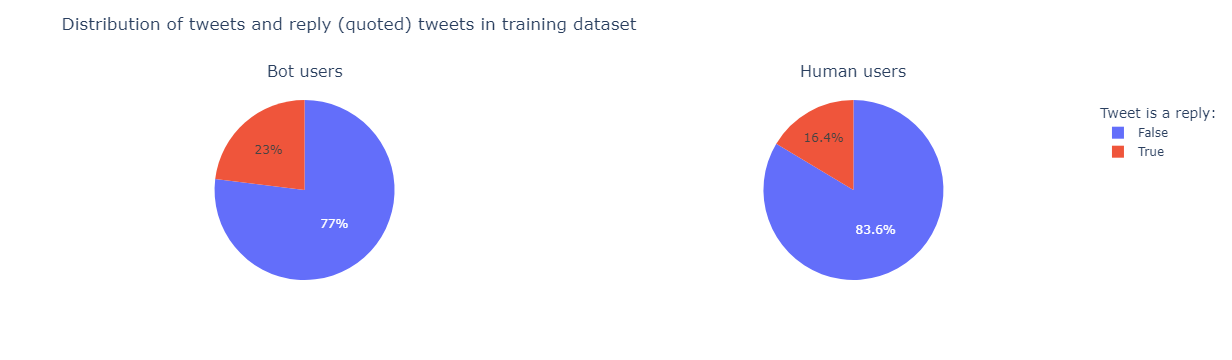

In [790]:
df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='is_reply')
df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='is_reply')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users","Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['is_reply'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['is_reply'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets and reply (quoted) tweets in training dataset',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet is a reply:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### is_reply (outliers removed)

In [791]:
train_tweets_data_is_reply_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='is_reply')

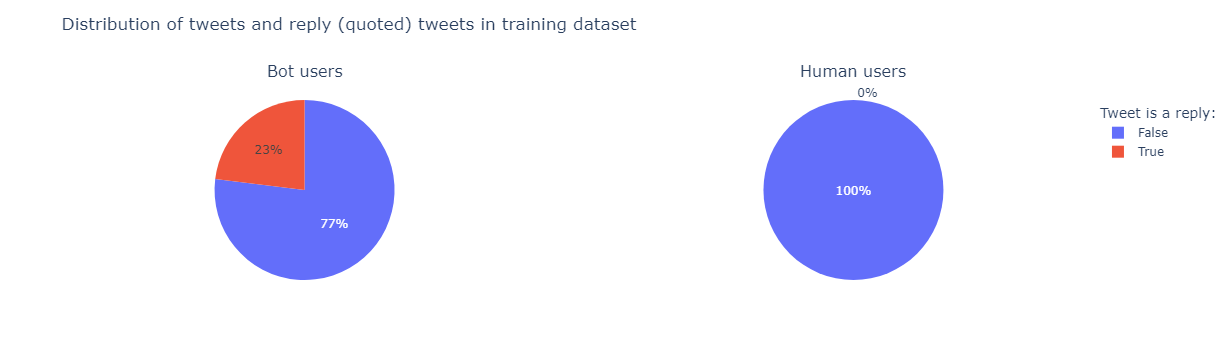

In [792]:
df_bots = get_mapped_freq_df(df=train_tweets_data_is_reply_outliers.loc[train_tweets_data_is_reply_outliers['author_label']==1], col_name='is_reply')
df_humans = get_mapped_freq_df(df=train_tweets_data_is_reply_outliers.loc[train_tweets_data_is_reply_outliers['author_label']==0], col_name='is_reply')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users","Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['is_reply'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['is_reply'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets and reply (quoted) tweets in training dataset',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet is a reply:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### copyright_infringement (column had all same values - dropped)

### geo_tagged

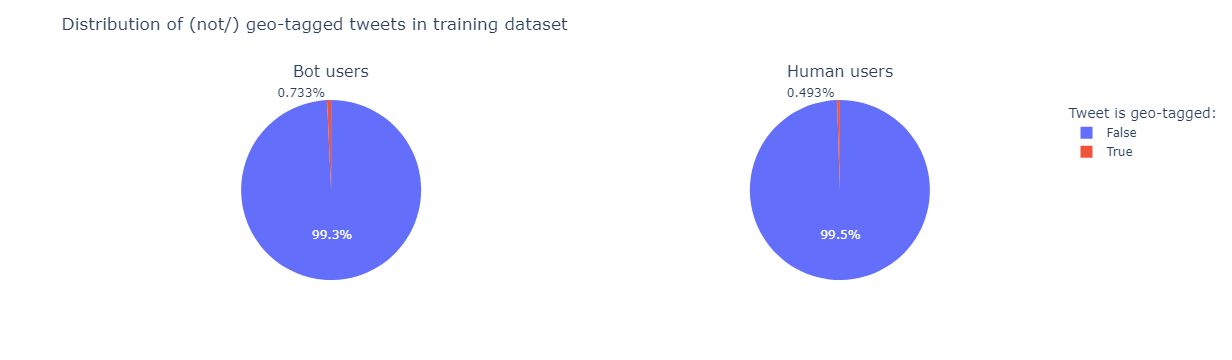

In [793]:
df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='geo_tagged')
df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='geo_tagged')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['geo_tagged'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['geo_tagged'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of (not/) geo-tagged tweets in training dataset',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet is geo-tagged:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### geo_tagged (outliers)

In [794]:
train_tweets_data_geo_tagged_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='geo_tagged')

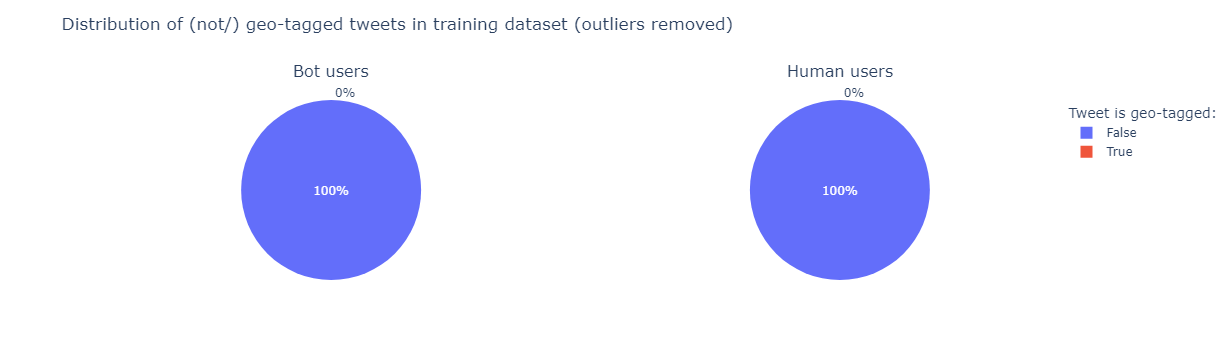

In [795]:
df_bots = get_mapped_freq_df(df=train_tweets_data_geo_tagged_outliers.loc[train_tweets_data_geo_tagged_outliers['author_label']==1], col_name='geo_tagged')
df_humans = get_mapped_freq_df(df=train_tweets_data_geo_tagged_outliers.loc[train_tweets_data_geo_tagged_outliers['author_label']==0], col_name='geo_tagged')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['geo_tagged'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['geo_tagged'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of (not/) geo-tagged tweets in training dataset (outliers removed)',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet is geo-tagged:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

Column to drop in outliers

### reply_settings (column had all same values - dropped)

In [796]:
# reply_settings_dict = {'everyone' : 0, 
#                        'following' : 1, 
#                        'mentionedUsers' : 2}

# list(reply_settings_dict.keys())

In [797]:
# dd = dict(train_tweets_data.loc[train_tweets_data['author_label']==1].groupby('reply_settings').apply(lambda x: x['reply_settings'].count()))
# freq1 = dd[0] if 0 in dd.keys() else 0
# freq2 = dd[1] if 1 in dd.keys() else 0
# freq3 = dd[2] if 2 in dd.keys() else 0
# mapping = {'reply_settings' : list(reply_settings_dict.keys()),
#      "freq": [freq1, freq2, freq3]}
# df_bots = pd.DataFrame(mapping)

# dd = dict(train_tweets_data.loc[train_tweets_data['author_label']==0].groupby('reply_settings').apply(lambda x: x['reply_settings'].count()))
# freq1 = dd[0] if 0 in dd.keys() else 0
# freq2 = dd[1] if 1 in dd.keys() else 0
# freq3 = dd[2] if 2 in dd.keys() else 0
# mapping = {'reply_settings' : list(reply_settings_dict.keys()),
#      "freq": [freq1, freq2, freq3]}
# df_humans = pd.DataFrame(mapping)
# # -------------------------------------------------------

# fig = go.Figure()
# fig = make_subplots(rows=1, 
#                     cols=2, 
#                     specs=[[{"type": "domain"}, {"type": "domain"}]],
#                     subplot_titles=("Bot users","Human users")
#                     # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
#                    )

# fig.add_trace(go.Pie(
#     labels=df_bots['reply_settings'], 
#     values=df_bots['freq']),
# row=1, col=1
# )
# fig.add_trace(go.Pie(
#     labels=df_humans['reply_settings'], 
#     values=df_humans['freq']),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of tweets reply settings in training dataset',
#     title_y=0.98,
#     # width=1100,
#     # height=450,
#     legend={"title":"Tweets' reply settings:"}
# )

# fig.update_annotations({'y': 1.2}, selector={'text': 'Bot users'})
# fig.update_annotations({'y': 1.2}, selector={'text': 'Human users'})

# fig.show()

<!-- ### reply_settings (outliers removed) -->

In [798]:
# train_tweets_data_reply_settings_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='reply_settings')

In [799]:
# dd = dict(train_tweets_data_reply_settings_outliers.loc[train_tweets_data_reply_settings_outliers['author_label']==1].groupby('reply_settings').apply(lambda x: x['reply_settings'].count()))
# freq1 = dd[0] if 0 in dd.keys() else 0
# freq2 = dd[1] if 1 in dd.keys() else 0
# freq3 = dd[2] if 2 in dd.keys() else 0
# mapping = {'reply_settings' : list(reply_settings_dict.keys()),
#      "freq": [freq1, freq2, freq3]}
# df_bots = pd.DataFrame(mapping)

# dd = dict(train_tweets_data_reply_settings_outliers.loc[train_tweets_data_reply_settings_outliers['author_label']==0].groupby('reply_settings').apply(lambda x: x['reply_settings'].count()))
# freq1 = dd[0] if 0 in dd.keys() else 0
# freq2 = dd[1] if 1 in dd.keys() else 0
# freq3 = dd[2] if 2 in dd.keys() else 0
# mapping = {'reply_settings' : list(reply_settings_dict.keys()),
#      "freq": [freq1, freq2, freq3]}
# df_humans = pd.DataFrame(mapping)
# # -------------------------------------------------------

# fig = go.Figure()
# fig = make_subplots(rows=1, 
#                     cols=2, 
#                     specs=[[{"type": "domain"}, {"type": "domain"}]],
#                     subplot_titles=("Bot users","Human users")
#                     # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
#                    )

# fig.add_trace(go.Pie(
#     labels=df_bots['reply_settings'], 
#     values=df_bots['freq']),
# row=1, col=1
# )
# fig.add_trace(go.Pie(
#     labels=df_humans['reply_settings'], 
#     values=df_humans['freq']),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of tweets reply settings in training dataset (outliers removed)',
#     title_y=0.98,
#     # width=1100,
#     # height=450,
#     legend={"title":"Tweets' reply settings:"}
# )

# fig.update_annotations({'y': 1.2}, selector={'text': 'Bot users'})
# fig.update_annotations({'y': 1.2}, selector={'text': 'Human users'})

# fig.show()

Column to drop

### any_polls_attached (column had all same values - dropped)

In [800]:
# df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='any_polls_attached')
# df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='any_polls_attached')
# # -------------------------------------------------------

# fig = go.Figure()
# fig = make_subplots(rows=1, 
#                     cols=2, 
#                     specs=[[{"type": "domain"}, {"type": "domain"}]],
#                     subplot_titles=("Bot users", "Human users")
#                     # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
#                    )

# fig.add_trace(go.Pie(
#     labels=df_bots['any_polls_attached'], 
#     values=df_bots['freq']),
# row=1, col=1
# )
# fig.add_trace(go.Pie(
#     labels=df_humans['any_polls_attached'], 
#     values=df_humans['freq']),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of tweets with/without pools attached in training dataset',
#     title_y=0.95,
#     # width=1100,
#     # height=450,
#     legend={"title":"Tweet has some pool attached:"}
# )

# fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
# fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

# fig.show()

### any_polls_attached (outliers removed)

In [801]:
# train_tweets_data_any_polls_attached_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='any_polls_attached')

In [802]:
# df_bots = get_mapped_freq_df(df=train_tweets_data_any_polls_attached_outliers.loc[train_tweets_data_any_polls_attached_outliers['author_label']==1], col_name='any_polls_attached')
# df_humans = get_mapped_freq_df(df=train_tweets_data_any_polls_attached_outliers.loc[train_tweets_data_any_polls_attached_outliers['author_label']==0], col_name='any_polls_attached')
# # -------------------------------------------------------

# fig = go.Figure()
# fig = make_subplots(rows=1, 
#                     cols=2, 
#                     specs=[[{"type": "domain"}, {"type": "domain"}]],
#                     subplot_titles=("Bot users", "Human users")
#                     # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
#                    )

# fig.add_trace(go.Pie(
#     labels=df_bots['any_polls_attached'], 
#     values=df_bots['freq']),
# row=1, col=1
# )
# fig.add_trace(go.Pie(
#     labels=df_humans['any_polls_attached'], 
#     values=df_humans['freq']),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of tweets with/without pools attached in training dataset (outliers removed)',
#     title_y=0.95,
#     # width=1100,
#     # height=450,
#     legend={"title":"Tweet has some pool attached:"}
# )

# fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
# fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

# fig.show()

Column to drop

### any_media_attached

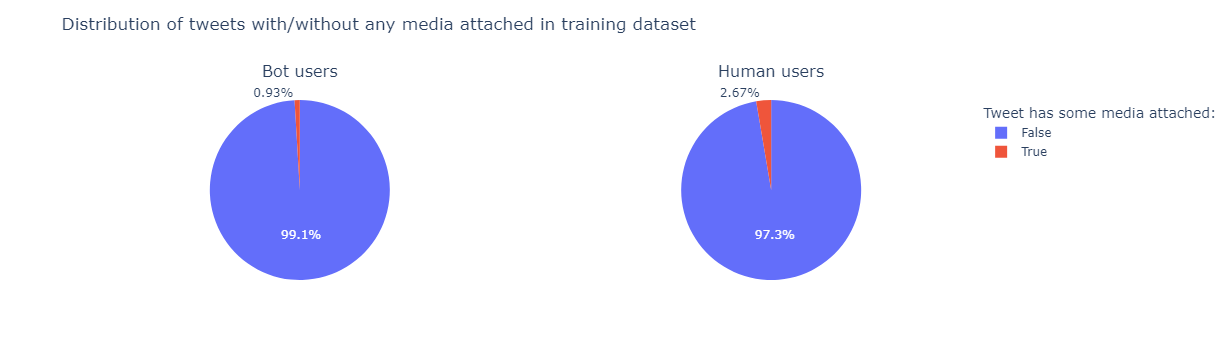

In [803]:
df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='any_media_attached')
df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='any_media_attached')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['any_media_attached'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['any_media_attached'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets with/without any media attached in training dataset',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet has some media attached:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### any_media_attached (outliers removed)

In [804]:
train_tweets_data_any_media_attached_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='any_media_attached')

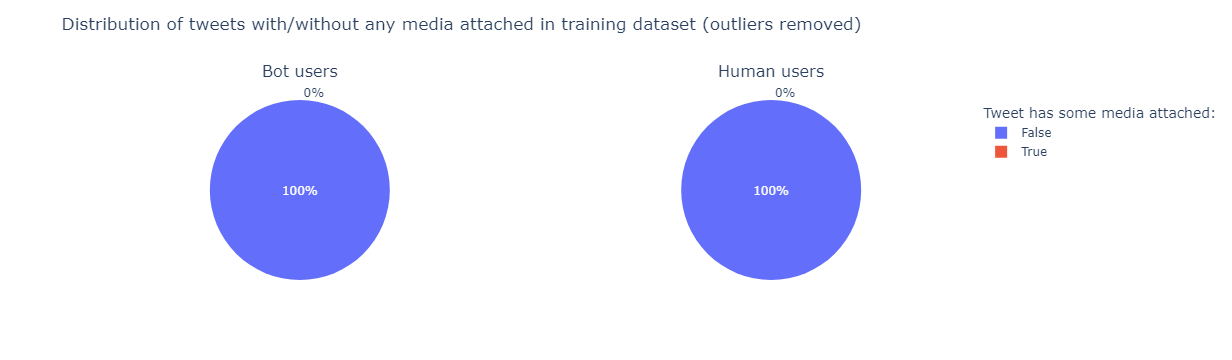

In [805]:
df_bots = get_mapped_freq_df(df=train_tweets_data_any_media_attached_outliers.loc[train_tweets_data_any_media_attached_outliers['author_label']==1], col_name='any_media_attached')
df_humans = get_mapped_freq_df(df=train_tweets_data_any_media_attached_outliers.loc[train_tweets_data_any_media_attached_outliers['author_label']==0], col_name='any_media_attached')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['any_media_attached'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['any_media_attached'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets with/without any media attached in training dataset (outliers removed)',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet has some media attached:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

Column to drop in outliers

### possibly_sensitive

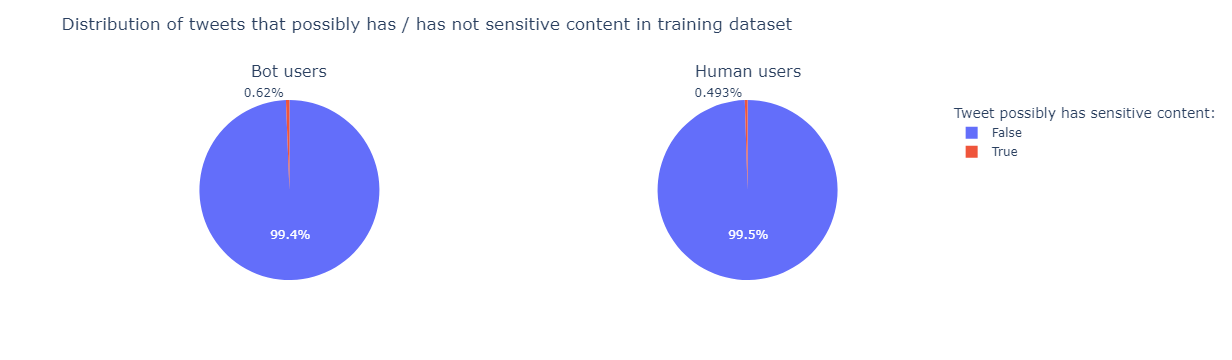

In [806]:
df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='possibly_sensitive')
df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='possibly_sensitive')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['possibly_sensitive'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['possibly_sensitive'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets that possibly has / has not sensitive content in training dataset',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet possibly has sensitive content:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### possibly_sensitive (without outliers)

In [807]:
train_tweets_data_possibly_sensitive_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='possibly_sensitive')

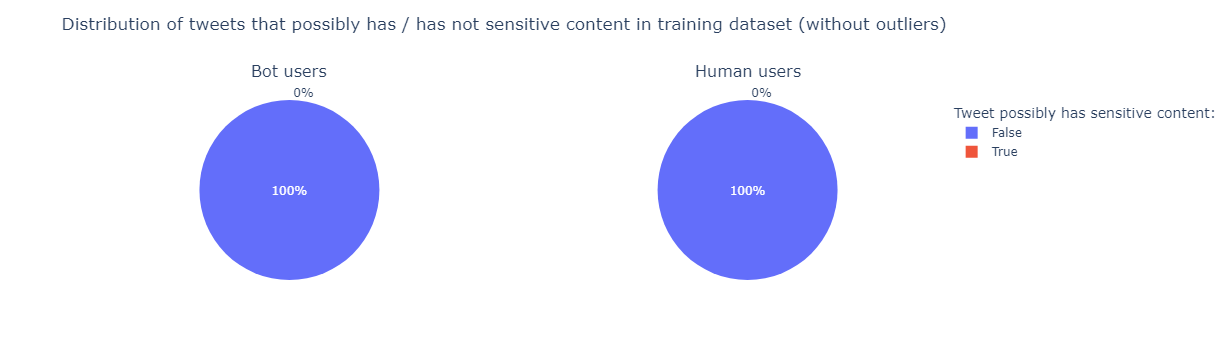

In [808]:
df_bots = get_mapped_freq_df(df=train_tweets_data_possibly_sensitive_outliers.loc[train_tweets_data_possibly_sensitive_outliers['author_label']==1], col_name='possibly_sensitive')
df_humans = get_mapped_freq_df(df=train_tweets_data_possibly_sensitive_outliers.loc[train_tweets_data_possibly_sensitive_outliers['author_label']==0], col_name='possibly_sensitive')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['possibly_sensitive'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['possibly_sensitive'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets that possibly has / has not sensitive content in training dataset (without outliers)',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet possibly has sensitive content:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

Column to drop in outliers

### has_referenced_tweets

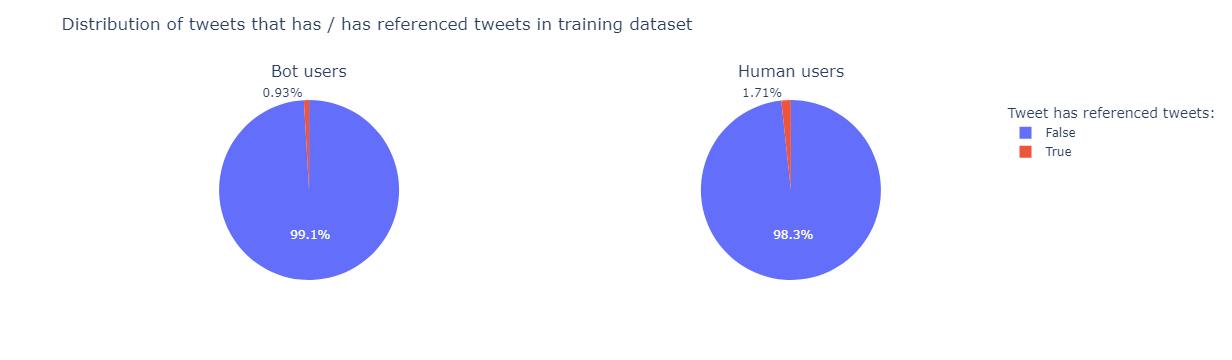

In [809]:
df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='has_referenced_tweets')
df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='has_referenced_tweets')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['has_referenced_tweets'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['has_referenced_tweets'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets that has / has referenced tweets in training dataset',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet has referenced tweets:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### has_referenced_tweets (outliers removed)

In [810]:
train_tweets_data_has_referenced_tweets_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='has_referenced_tweets')

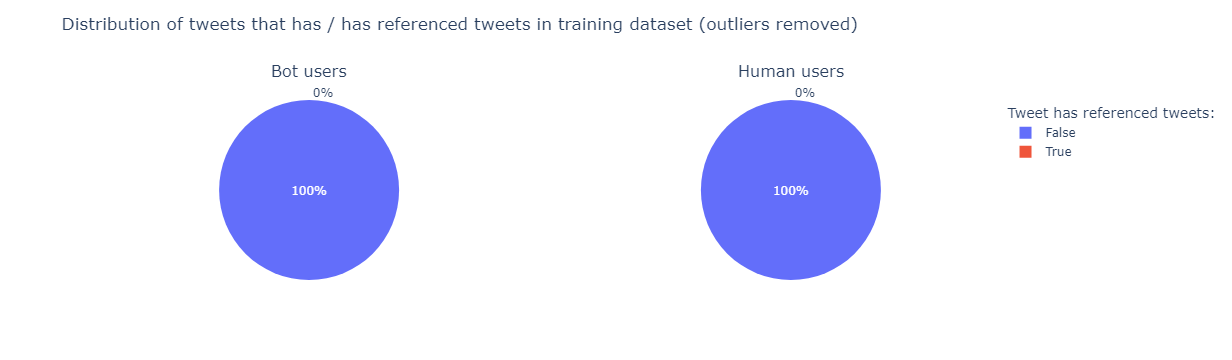

In [811]:
df_bots = get_mapped_freq_df(df=train_tweets_data_has_referenced_tweets_outliers.loc[train_tweets_data_has_referenced_tweets_outliers['author_label']==1], col_name='has_referenced_tweets')
df_humans = get_mapped_freq_df(df=train_tweets_data_has_referenced_tweets_outliers.loc[train_tweets_data_has_referenced_tweets_outliers['author_label']==0], col_name='has_referenced_tweets')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['has_referenced_tweets'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['has_referenced_tweets'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets that has / has referenced tweets in training dataset (outliers removed)',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet has referenced tweets:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### contains_images (column had all same values - dropped)

In [812]:
# df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='contains_images')
# df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='contains_images')
# # -------------------------------------------------------

# fig = go.Figure()
# fig = make_subplots(rows=1, 
#                     cols=2, 
#                     specs=[[{"type": "domain"}, {"type": "domain"}]],
#                     subplot_titles=("Bot users", "Human users")
#                     # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
#                    )

# fig.add_trace(go.Pie(
#     labels=df_bots['contains_images'], 
#     values=df_bots['freq']),
# row=1, col=1
# )
# fig.add_trace(go.Pie(
#     labels=df_humans['contains_images'], 
#     values=df_humans['freq']),
# row=1, col=2
# )

# fig.update_layout(
#     title_text='Distribution of tweets that not/ contains images in training dataset',
#     title_y=0.95,
#     # width=1100,
#     # height=450,
#     legend={"title":"Tweet contains images:"}
# )

# fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
# fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

# fig.show()

### contains_annotations

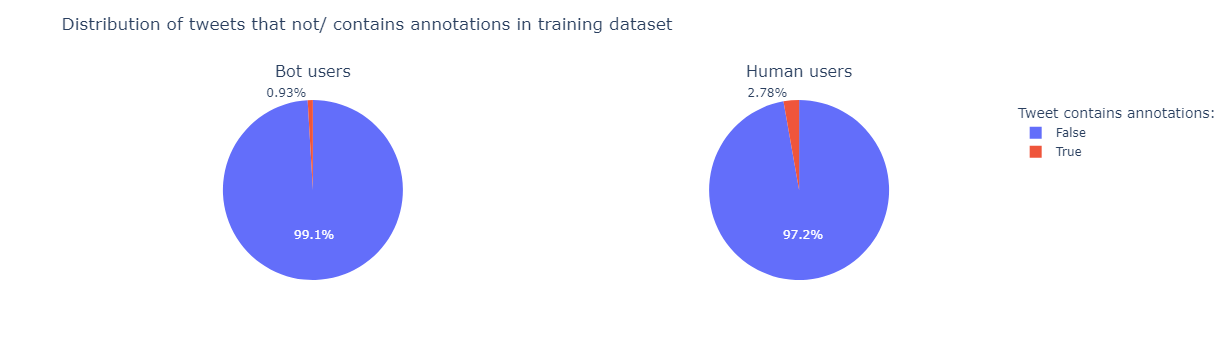

In [813]:
df_bots = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==1], col_name='contains_annotations')
df_humans = get_mapped_freq_df(df=train_tweets_data.loc[train_tweets_data['author_label']==0], col_name='contains_annotations')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['contains_annotations'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['contains_annotations'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets that not/ contains annotations in training dataset',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet contains annotations:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

### contains_annotations (outliers removed)

In [814]:
train_tweets_data_contains_annotations_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='contains_annotations')

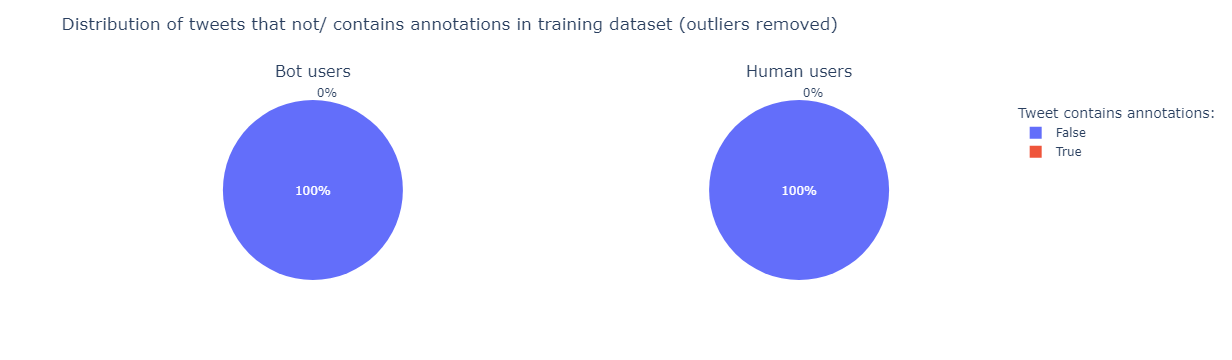

In [815]:
df_bots = get_mapped_freq_df(df=train_tweets_data_contains_annotations_outliers.loc[train_tweets_data_contains_annotations_outliers['author_label']==1], col_name='contains_annotations')
df_humans = get_mapped_freq_df(df=train_tweets_data_contains_annotations_outliers.loc[train_tweets_data_contains_annotations_outliers['author_label']==0], col_name='contains_annotations')
# -------------------------------------------------------

fig = go.Figure()
fig = make_subplots(rows=1, 
                    cols=2, 
                    specs=[[{"type": "domain"}, {"type": "domain"}]],
                    subplot_titles=("Bot users", "Human users")
                    # specs=[[{'type':'histogram'}, {'type':'histogram'}]]
                   )

fig.add_trace(go.Pie(
    labels=df_bots['contains_annotations'], 
    values=df_bots['freq']),
row=1, col=1
)
fig.add_trace(go.Pie(
    labels=df_humans['contains_annotations'], 
    values=df_humans['freq']),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of tweets that not/ contains annotations in training dataset (outliers removed)',
    title_y=0.95,
    # width=1100,
    # height=450,
    legend={"title":"Tweet contains annotations:"}
)

fig.update_annotations({'y': 1.1}, selector={'text': 'Bot users'})
fig.update_annotations({'y': 1.1}, selector={'text': 'Human users'})

fig.show()

Column to drop in outliers

### retweet_count

In [816]:
train_tweets_data['retweet_count'] = train_tweets_data['retweet_count'].astype(int)

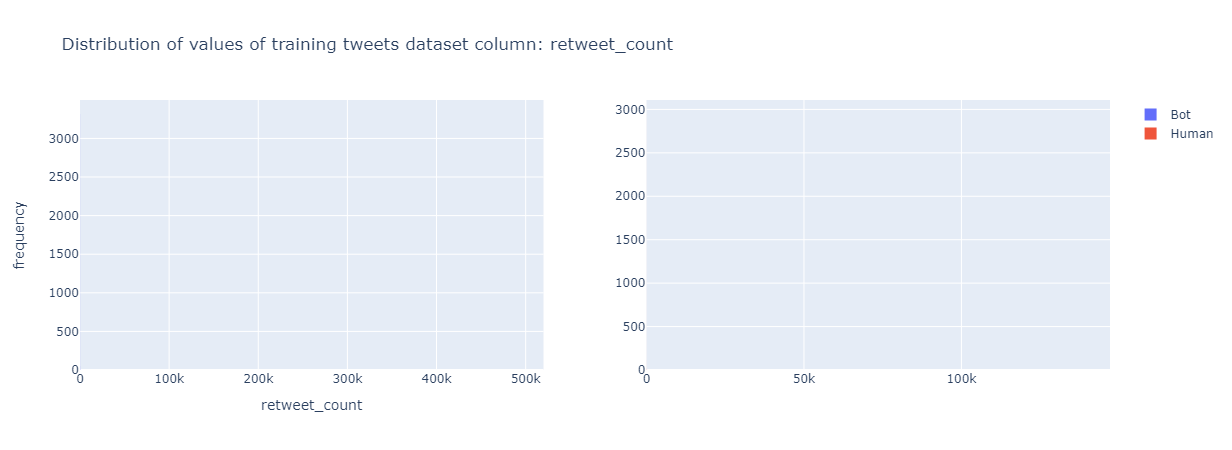

In [817]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['retweet_count'],
    # histnorm='density',
    nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['retweet_count'],
    # histnorm='density',
    nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: retweet_count',
    xaxis_title_text='retweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='retweet_count', 
               #dtick=50000, 
               # range=[0, 10000]
              ),
    xaxis2=dict(showgrid=True, 
                #dtick=100000, 
                # range=[0, 10000]
               ),
    yaxis=dict(showgrid=True))

fig.show()

### retweet_count (outliers removed)

In [818]:
train_tweets_data['retweet_count'].dtype

dtype('int64')

In [819]:
train_tweets_data_retweet_count_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='retweet_count')

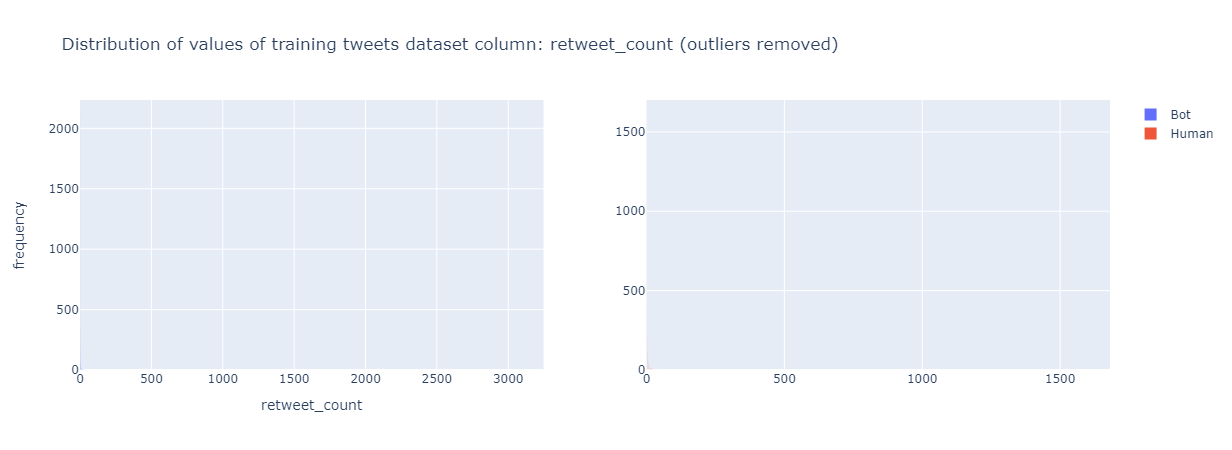

In [820]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_retweet_count_outliers.loc[train_tweets_data_retweet_count_outliers['author_label']==1]['retweet_count'],
    # histnorm='density',
    nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_retweet_count_outliers.loc[train_tweets_data_retweet_count_outliers['author_label']==0]['retweet_count'],
    # histnorm='density',
    nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: retweet_count (outliers removed)',
    xaxis_title_text='retweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='retweet_count', 
               #dtick=50000, 
               # range=[0, 10000]
              ),
    xaxis2=dict(showgrid=True, 
                #dtick=100000, 
                # range=[0, 10000]
               ),
    yaxis=dict(showgrid=True))

fig.show()

### reply_count

In [821]:
train_tweets_data['reply_count'] = train_tweets_data['reply_count'].astype(int)

In [822]:
train_tweets_data.loc[train_tweets_data['author_label']==1]['reply_count'].describe()

count    3549.000000
mean        0.023950
std         0.673413
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        35.000000
Name: reply_count, dtype: float64

In [823]:
train_tweets_data.loc[train_tweets_data['author_label']==0]['reply_count'].describe()

count    3451.000000
mean        1.029846
std        35.086898
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1800.000000
Name: reply_count, dtype: float64

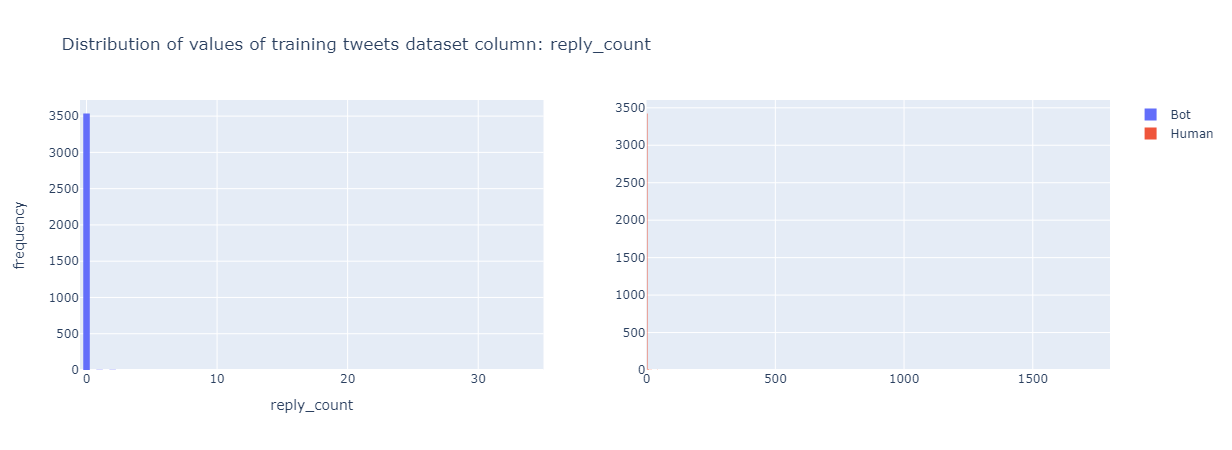

In [824]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['reply_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['reply_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: reply_count',
    xaxis_title_text='reply_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='reply_count', 
               # dtick=10, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['reply_count'])]
              ),
    xaxis2=dict(showgrid=True, 
                # dtick=10, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['reply_count'])]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### retweet_count (outliers removed)

In [825]:
train_tweets_data_retweet_count_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='retweet_count')

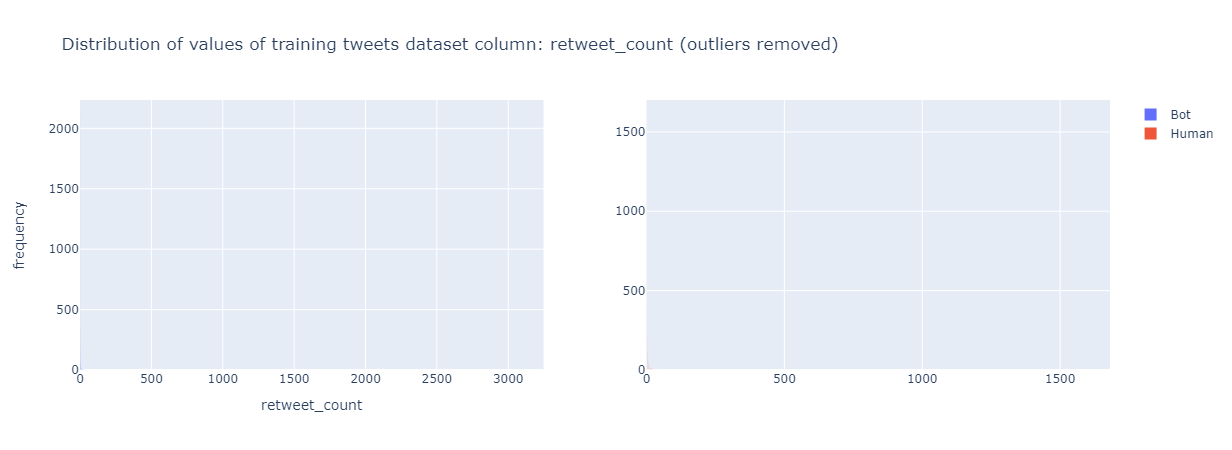

In [826]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_retweet_count_outliers.loc[train_tweets_data_retweet_count_outliers['author_label']==1]['retweet_count'],
    # histnorm='density',
    nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_retweet_count_outliers.loc[train_tweets_data_retweet_count_outliers['author_label']==0]['retweet_count'],
    # histnorm='density',
    nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: retweet_count (outliers removed)',
    xaxis_title_text='retweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='retweet_count', 
               #dtick=50000, 
               # range=[0, 10000]
              ),
    xaxis2=dict(showgrid=True, 
                #dtick=100000, 
                # range=[0, 10000]
               ),
    yaxis=dict(showgrid=True))

fig.show()

### like_count

In [827]:
train_tweets_data['like_count'] = train_tweets_data['like_count'].astype(int)

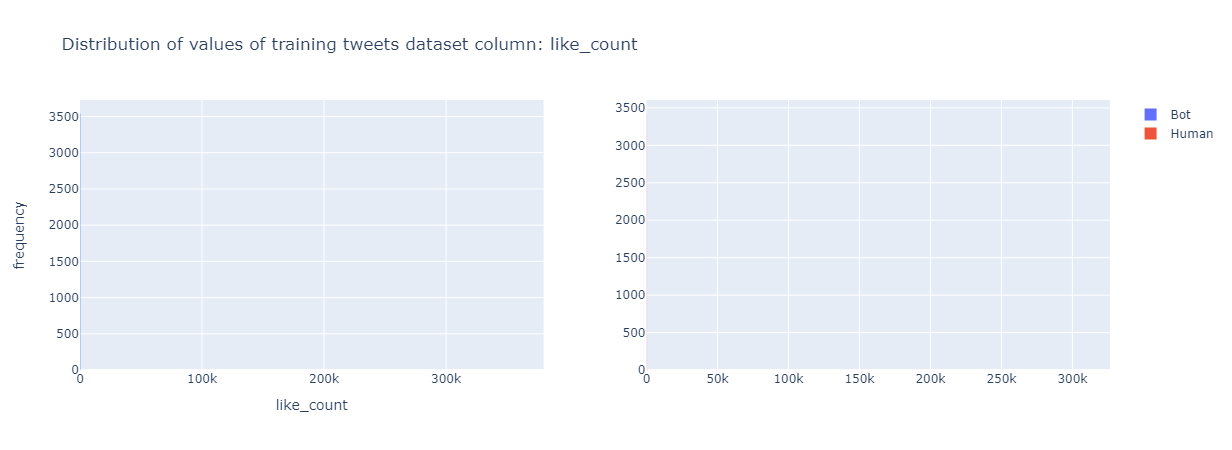

In [828]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['like_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['like_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: like_count',
    xaxis_title_text='like_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='like_count', 
               # dtick=10, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['like_count'])]
              ),
    xaxis2=dict(showgrid=True, 
                # dtick=10, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['like_count'])]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### like_count (outliers removed)

In [829]:
train_tweets_data_like_count_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='like_count')

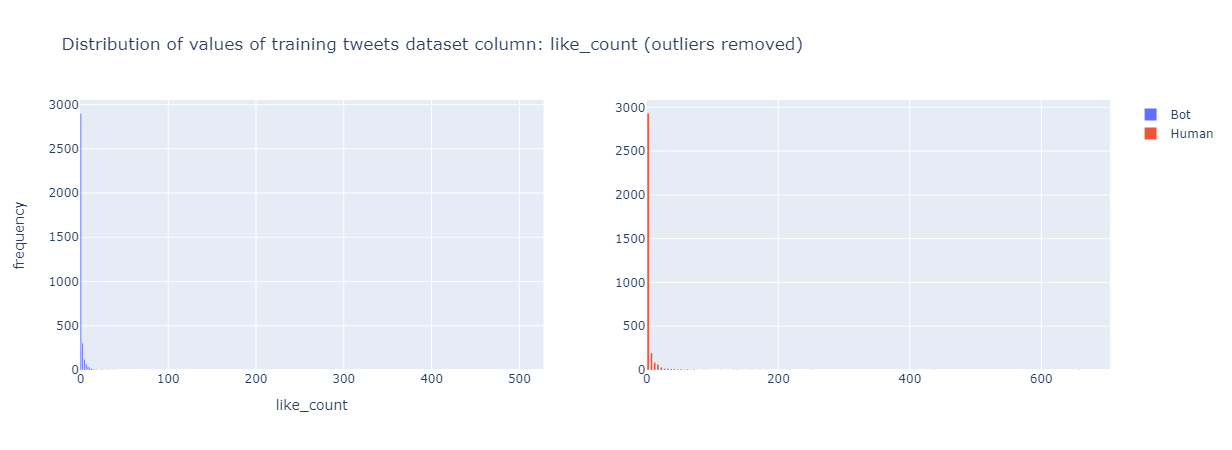

In [830]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_like_count_outliers.loc[train_tweets_data_like_count_outliers['author_label']==1]['like_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_like_count_outliers.loc[train_tweets_data_like_count_outliers['author_label']==0]['like_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: like_count (outliers removed)',
    xaxis_title_text='like_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='like_count', 
               # dtick=10, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['like_count'])]
              ),
    xaxis2=dict(showgrid=True, 
                # dtick=10, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['like_count'])]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

## quote_count

In [831]:
train_tweets_data['quote_count'] = train_tweets_data['quote_count'].astype(int)

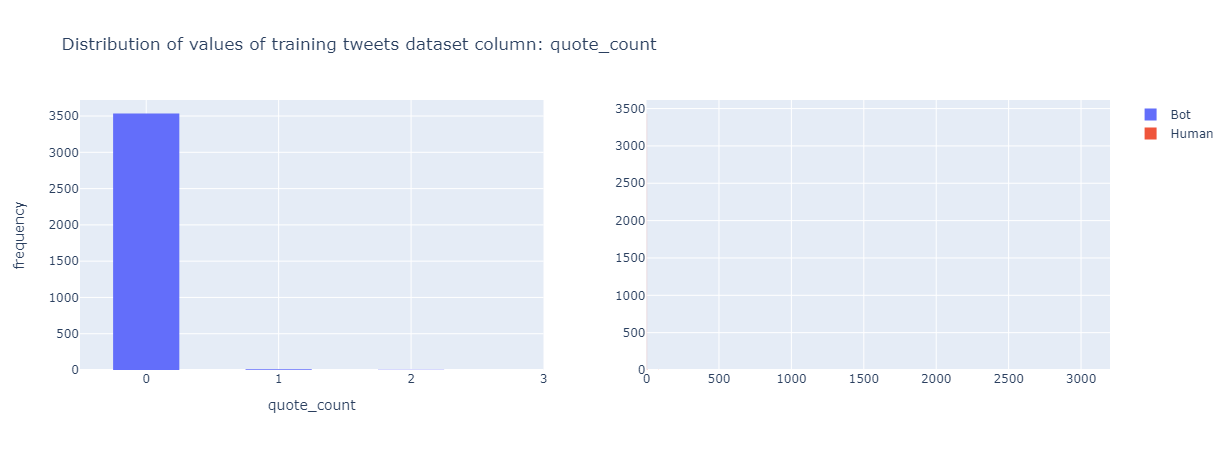

In [832]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['quote_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['quote_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: quote_count',
    xaxis_title_text='quote_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='quote_count', 
               # dtick=10, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['quote_count'])]
              ),
    xaxis2=dict(showgrid=True, 
                # dtick=10, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['quote_count'])]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### quote_count (outliers removed)

In [833]:
train_tweets_data_quote_count_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='quote_count')

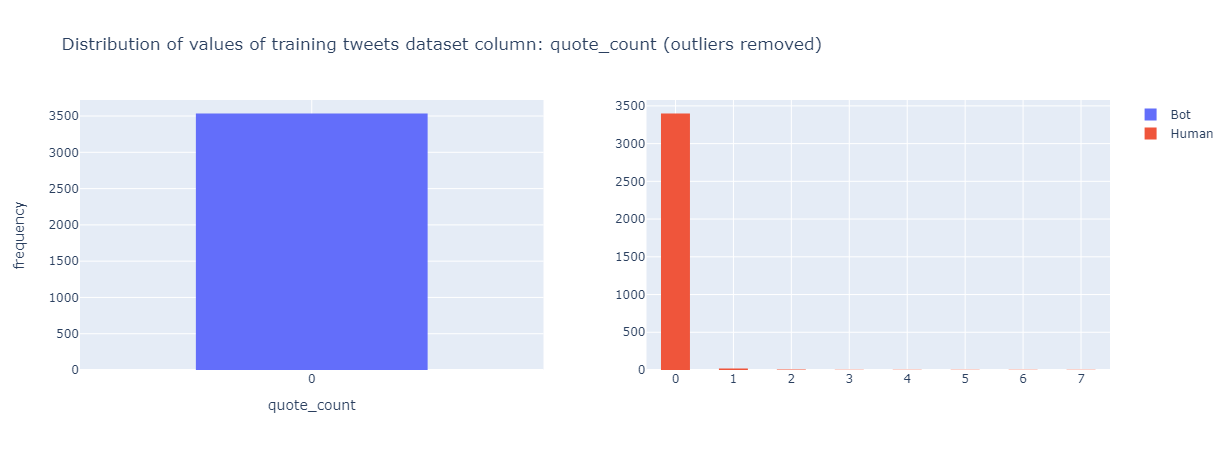

In [834]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_quote_count_outliers.loc[train_tweets_data_quote_count_outliers['author_label']==1]['quote_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_quote_count_outliers.loc[train_tweets_data_quote_count_outliers['author_label']==0]['quote_count'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: quote_count (outliers removed)',
    xaxis_title_text='quote_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='quote_count', 
               dtick=1, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['quote_count'])]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['quote_count'])]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_cashtags

In [835]:
train_tweets_data['no_cashtags'] = train_tweets_data['no_cashtags'].astype(int)

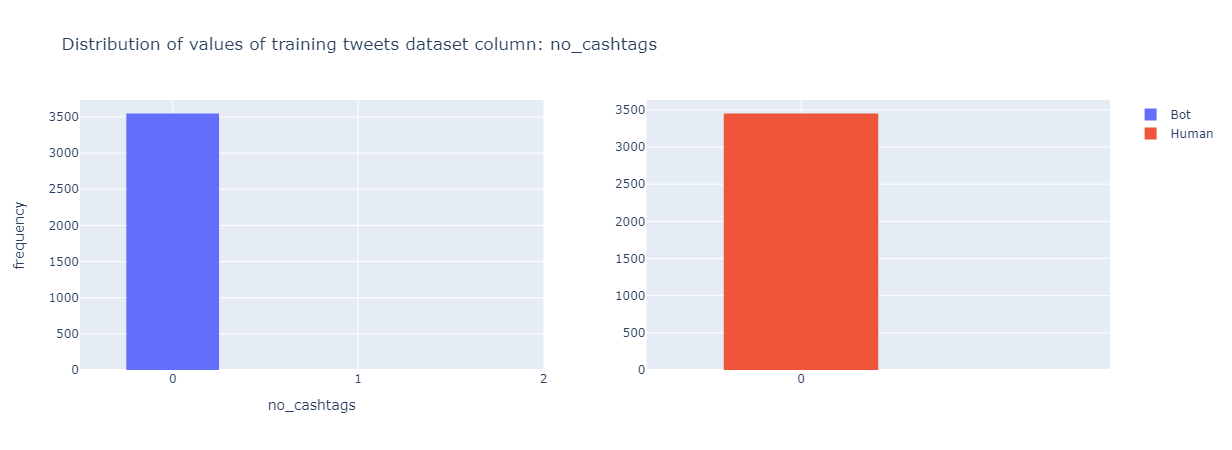

In [836]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['no_cashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['no_cashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_cashtags',
    xaxis_title_text='no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_cashtags', 
               dtick=1, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_cashtags']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=2, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_cashtags']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_cashtags (outliers removed)

In [837]:
train_tweets_data_no_cashtags_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='no_cashtags')

/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



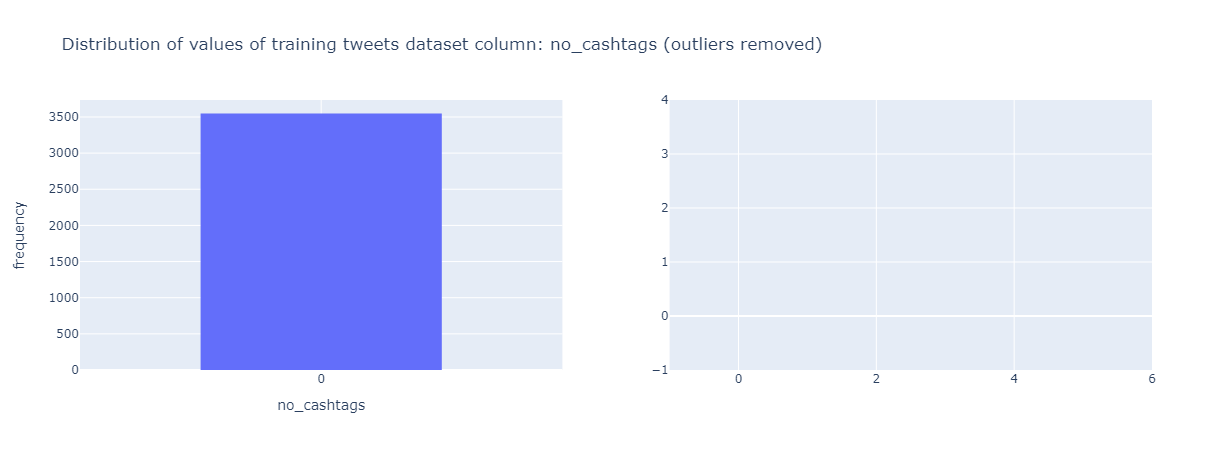

In [838]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_no_cashtags_outliers.loc[train_tweets_data_no_cashtags_outliers['author_label']==1]['no_cashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_no_cashtags_outliers.loc[train_tweets_data_no_cashtags_outliers['author_label']==0]['no_cashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_cashtags (outliers removed)',
    xaxis_title_text='no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_cashtags', 
               dtick=1, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_cashtags']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=2, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_cashtags']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

Column to drop in outliers

### no_mentions

In [839]:
train_tweets_data['no_mentions'] = train_tweets_data['no_mentions'].astype(int)

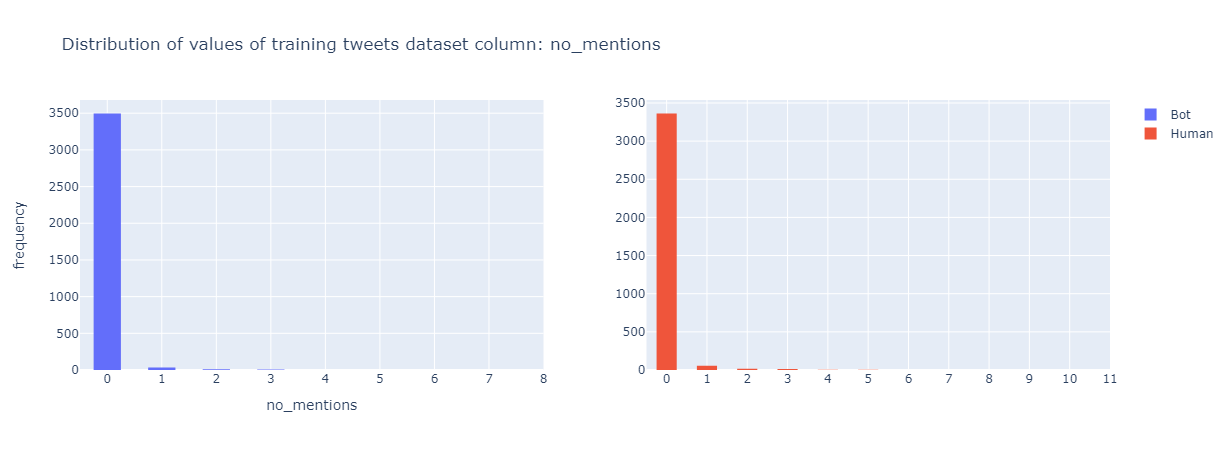

In [840]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['no_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['no_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_mentions',
    xaxis_title_text='no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_mentions', 
               dtick=1, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_mentions']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_mentions']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_mentions (outliers removed)

In [841]:
train_tweets_data_no_mentions_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='no_mentions')

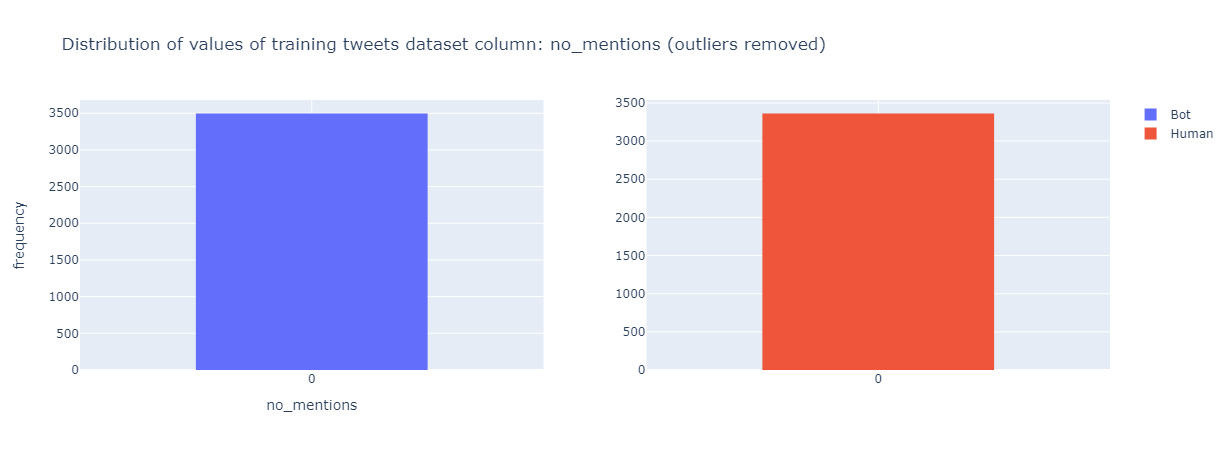

In [842]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_no_mentions_outliers.loc[train_tweets_data_no_mentions_outliers['author_label']==1]['no_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_no_mentions_outliers.loc[train_tweets_data_no_mentions_outliers['author_label']==0]['no_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_mentions (outliers removed)',
    xaxis_title_text='no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_mentions', 
               dtick=1, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_mentions']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_mentions']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

Column to remove in outliers

### no_user_mentions

In [843]:
train_tweets_data['no_user_mentions'] = train_tweets_data['no_user_mentions'].astype(int)

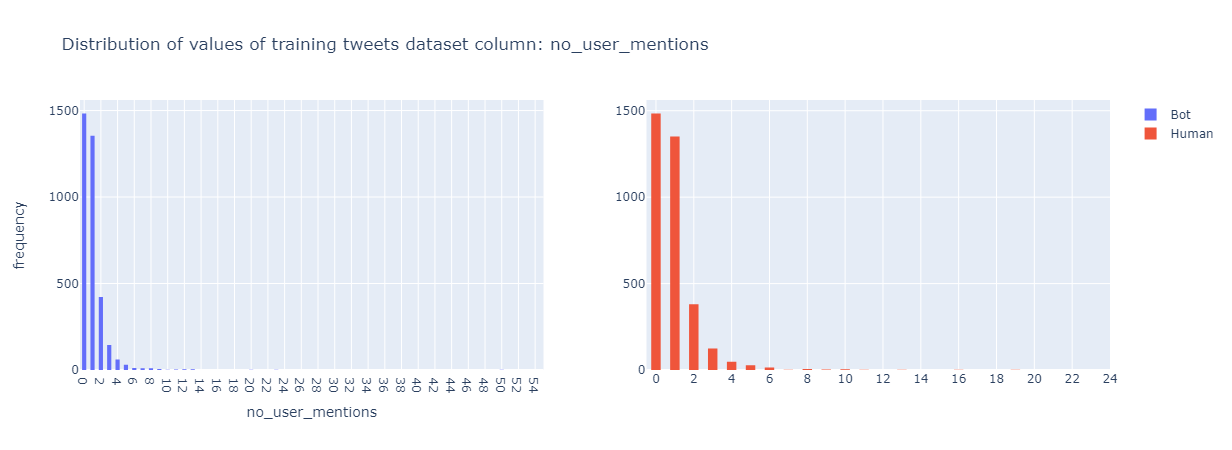

In [844]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['no_user_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['no_user_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_user_mentions',
    xaxis_title_text='no_user_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_user_mentions', 
               dtick=2, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_user_mentions']+5)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=2, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_user_mentions']+5)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_user_mentions (outliers removed)

In [845]:
train_tweets_data_no_user_mentions_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='no_user_mentions')

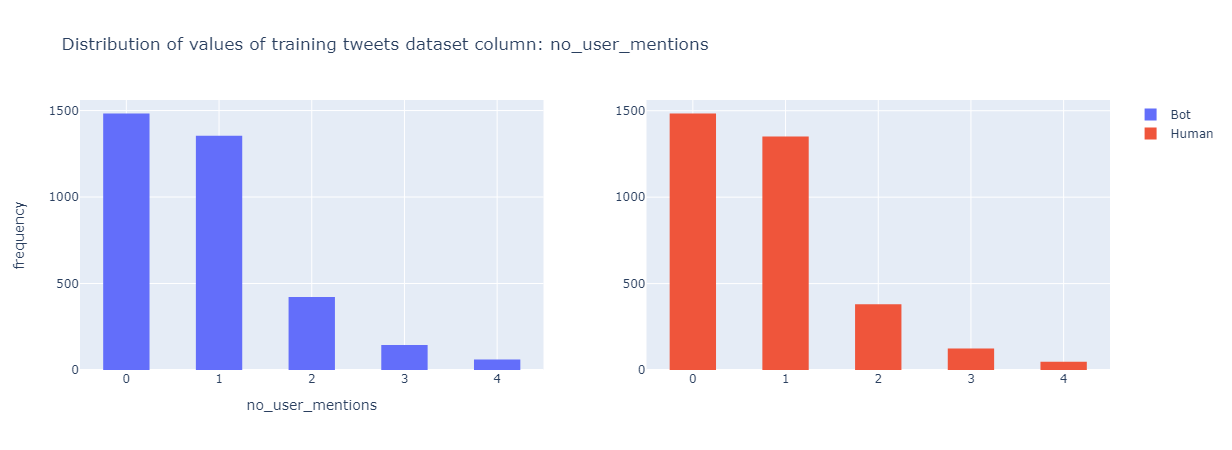

In [846]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_no_user_mentions_outliers.loc[train_tweets_data_no_user_mentions_outliers['author_label']==1]['no_user_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_no_user_mentions_outliers.loc[train_tweets_data_no_user_mentions_outliers['author_label']==0]['no_user_mentions'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_user_mentions',
    xaxis_title_text='no_user_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_user_mentions', 
               dtick=1, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_user_mentions']+5)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_user_mentions']+5)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_urls

In [847]:
train_tweets_data['no_urls'] = train_tweets_data['no_urls'].astype(int)

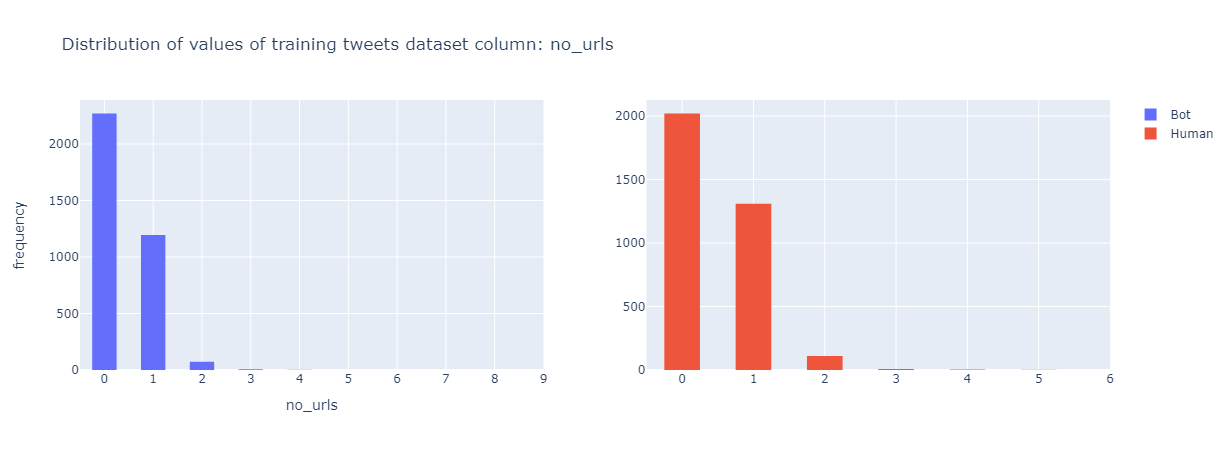

In [848]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['no_urls'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['no_urls'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_urls',
    xaxis_title_text='no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_urls', 
               dtick=1, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_urls']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_urls']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_urls (outliers removed)

In [849]:
train_tweets_data_no_urls_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='no_urls')

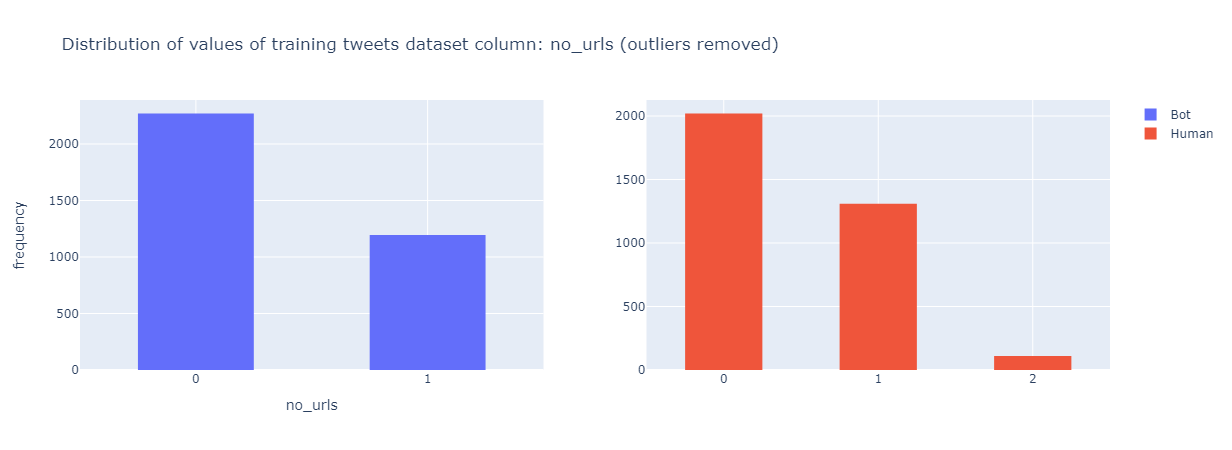

In [850]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_no_urls_outliers.loc[train_tweets_data_no_urls_outliers['author_label']==1]['no_urls'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_no_urls_outliers.loc[train_tweets_data_no_urls_outliers['author_label']==0]['no_urls'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_urls (outliers removed)',
    xaxis_title_text='no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_urls', 
               dtick=1, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_urls']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_urls']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_hashtags

In [851]:
train_tweets_data['no_hashtags'] = train_tweets_data['no_hashtags'].astype(int)

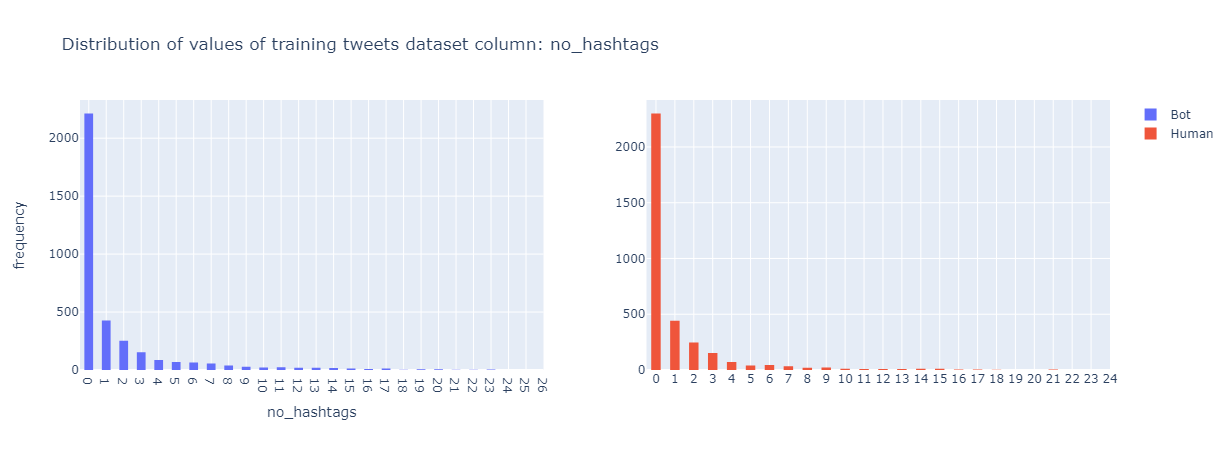

In [852]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['no_hashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['no_hashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_hashtags',
    xaxis_title_text='no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_hashtags', 
               dtick=1, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_hashtags'])]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_hashtags'])]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### no_hashtags (outliers removed)

In [853]:
train_tweets_data_no_hashtags_outliers = df_99_percentile_expon(df=train_tweets_data, column_name='no_hashtags')

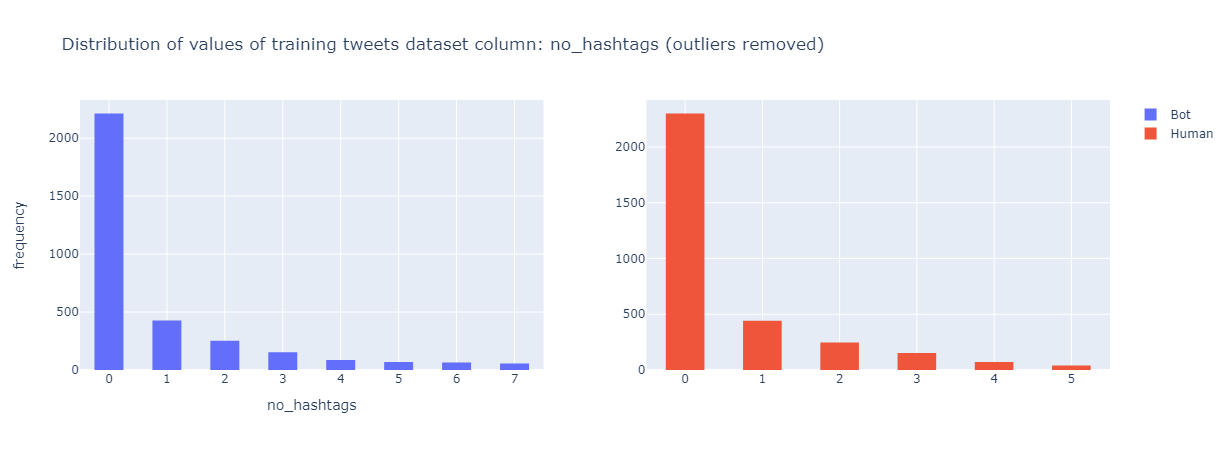

In [854]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_no_hashtags_outliers.loc[train_tweets_data_no_hashtags_outliers['author_label']==1]['no_hashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_no_hashtags_outliers.loc[train_tweets_data_no_hashtags_outliers['author_label']==0]['no_hashtags'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: no_hashtags (outliers removed)',
    xaxis_title_text='no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='no_hashtags', 
               dtick=1, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['no_hashtags'])]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=1, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['no_hashtags'])]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### org_tweet_len

In [855]:
train_tweets_data['org_tweet_len'] = train_tweets_data['org_tweet_len'].astype(int)

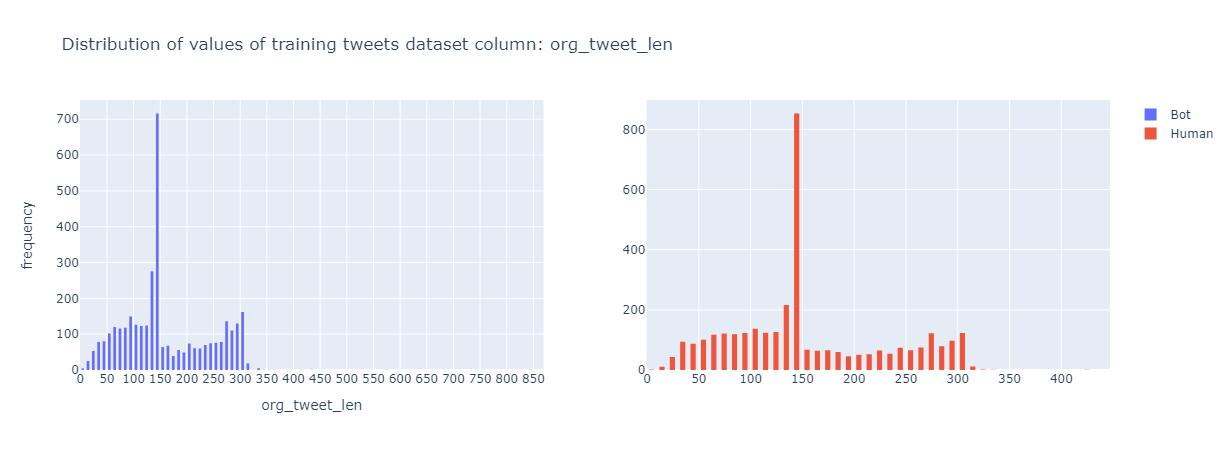

In [856]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['org_tweet_len'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['org_tweet_len'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: org_tweet_len',
    xaxis_title_text='org_tweet_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='org_tweet_len', 
               dtick=50, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['org_tweet_len']+25)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=50, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['org_tweet_len']+25)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### org_tweet_len (outliers removed)

In [857]:
train_tweets_data_org_tweet_len_outliers = df_99_percentile_norm(df=train_tweets_data, column_name='org_tweet_len')

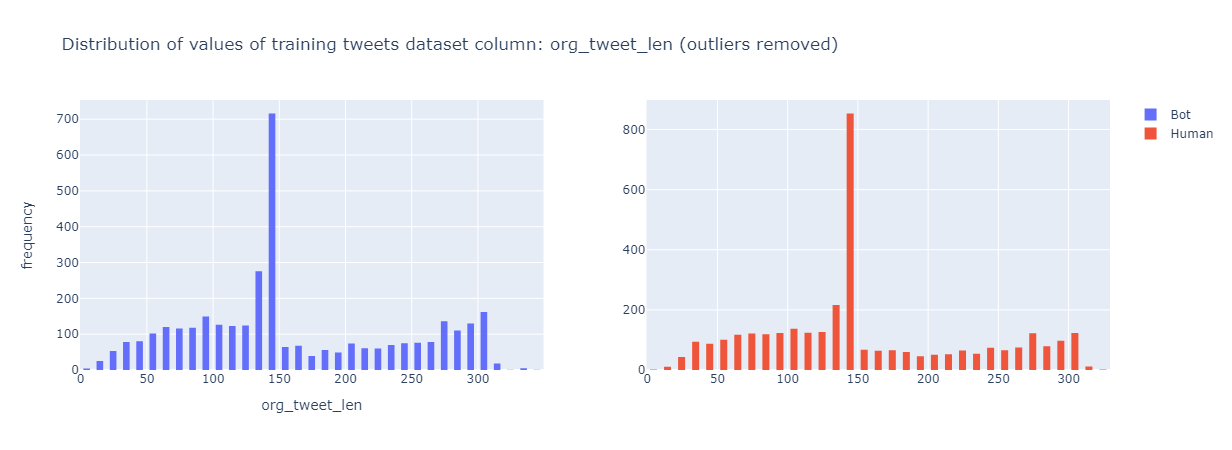

In [858]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_org_tweet_len_outliers.loc[train_tweets_data_org_tweet_len_outliers['author_label']==1]['org_tweet_len'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_org_tweet_len_outliers.loc[train_tweets_data_org_tweet_len_outliers['author_label']==0]['org_tweet_len'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: org_tweet_len (outliers removed)',
    xaxis_title_text='org_tweet_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='org_tweet_len', 
               dtick=50, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['org_tweet_len']+25)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=50, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['org_tweet_len']+25)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### time_of_creation (min of the day)

In [859]:
train_tweets_data['time_of_creation'] = train_tweets_data['time_of_creation'].astype(int)

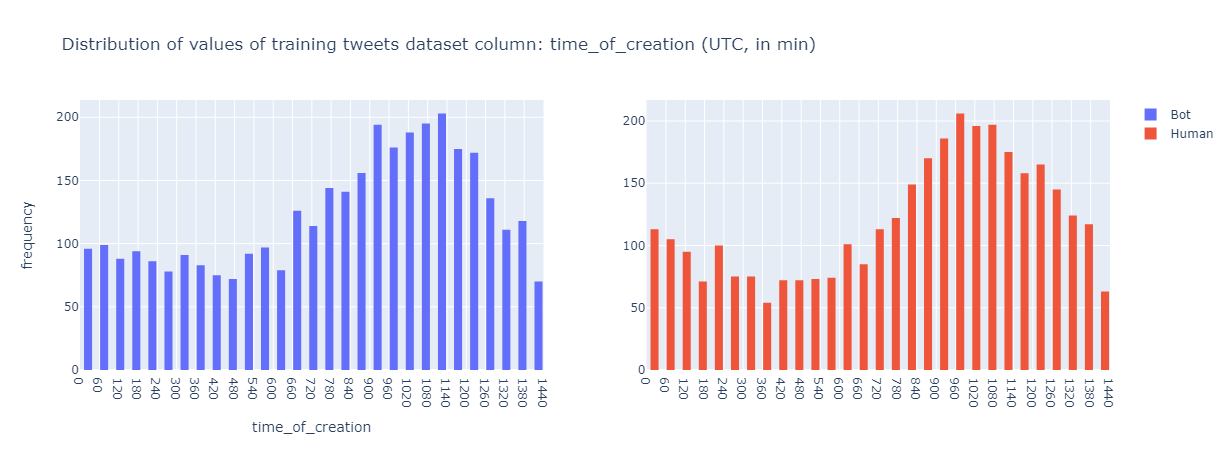

In [860]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==1]['time_of_creation'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data.loc[train_tweets_data['author_label']==0]['time_of_creation'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: time_of_creation (UTC, in min)',
    xaxis_title_text='time_of_creation', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='time_of_creation', 
               dtick=60, 
               range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['time_of_creation']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=60, 
                range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['time_of_creation']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

### time_of_creation (min of the day) (outliers removed)

In [861]:
train_tweets_data_time_of_creation_outliers = df_99_percentile_norm(df=train_tweets_data, column_name='time_of_creation')

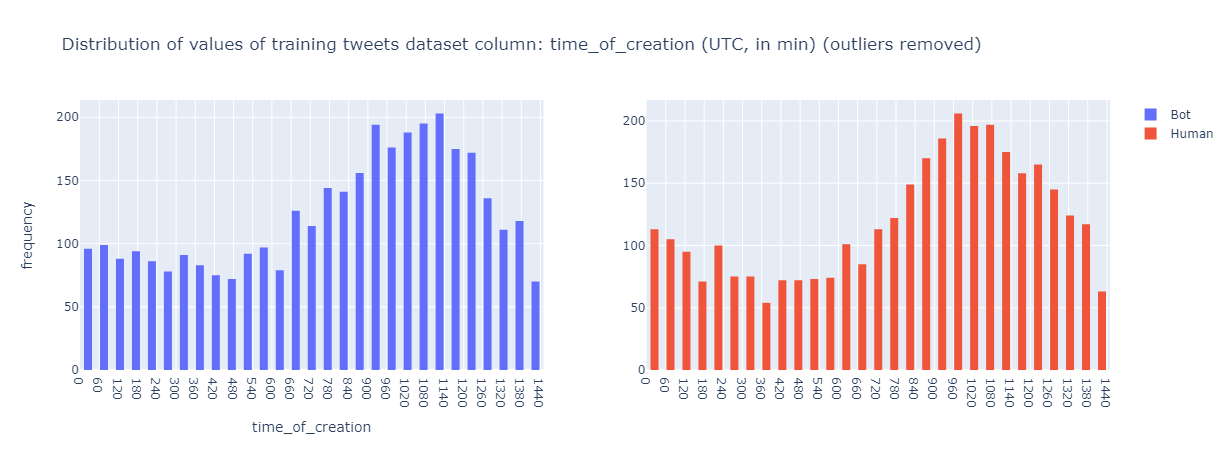

In [862]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_tweets_data_time_of_creation_outliers.loc[train_tweets_data_time_of_creation_outliers['author_label']==1]['time_of_creation'],
    # histnorm='density',
    # nbinsx=10000,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_tweets_data_time_of_creation_outliers.loc[train_tweets_data_time_of_creation_outliers['author_label']==0]['time_of_creation'],
    # histnorm='density',
    # nbinsx=10000,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training tweets dataset column: time_of_creation (UTC, in min) (outliers removed)',
    xaxis_title_text='time_of_creation', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='time_of_creation', 
               dtick=60, 
               # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==1]['time_of_creation']+1)]
              ),
    xaxis2=dict(showgrid=True, 
                dtick=60, 
                # range=[-0.5, max(train_tweets_data.loc[train_tweets_data['author_label']==0]['time_of_creation']+1)]
               ),
    yaxis=dict(showgrid=True, 
               # range=[0, 100]
              ),
    yaxis2=dict(showgrid=True, 
                # range=[0, 100]
               ))

fig.show()

## Create merged dataframe from reduced by columns outliers dataframes

In [863]:
train_tweets_data_wo_outliers = train_tweets_data_is_reply_outliers.merge(train_tweets_data_geo_tagged_outliers, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [ train_tweets_data_any_media_attached_outliers,
                train_tweets_data_possibly_sensitive_outliers,
                train_tweets_data_has_referenced_tweets_outliers,
                train_tweets_data_contains_annotations_outliers,
                train_tweets_data_retweet_count_outliers,
                train_tweets_data_retweet_count_outliers,
                train_tweets_data_like_count_outliers,
                train_tweets_data_quote_count_outliers,
                train_tweets_data_no_cashtags_outliers,
                train_tweets_data_no_mentions_outliers,
                train_tweets_data_no_user_mentions_outliers,
                train_tweets_data_no_urls_outliers,
                train_tweets_data_no_hashtags_outliers,
                train_tweets_data_org_tweet_len_outliers,
                train_tweets_data_time_of_creation_outliers]

for df in rest_of_df:
    if (len(df.loc[df['author_label']==1]) > 0 and len(df.loc[df['author_label']==0]) > 0):
        train_tweets_data_wo_outliers = train_tweets_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

### Create same dataframe for validation and test set to for set without outliers

In [864]:
val_tweets_data_wo_outliers = pd.DataFrame(val_tweets_data).copy()
test_tweets_data_wo_outliers = pd.DataFrame(test_tweets_data).copy()

### Drop columns in dataframes with out outliers where there are same value in whole columns (in training dataset without outliers)

In [865]:
not_simple_numeric_col = ['id', 'author_id', 'created_at', 'org_text', 'text', 'source', 'conversation_id',
                          'user_mentions', 'hashtags', 'created_at_datetime', 'cleaned_tweet_len', 'org_tweet_len', 
                          'author_label']

In [866]:
same_data_columns_wo = list(train_tweets_data_wo_outliers.drop(not_simple_numeric_col, axis=1).columns[train_tweets_data_wo_outliers.drop(not_simple_numeric_col, axis=1).apply(lambda x: x.nunique()) == 1])
same_data_columns_wo

['geo_tagged',
 'any_media_attached',
 'possibly_sensitive',
 'has_referenced_tweets',
 'no_cashtags',
 'no_mentions',
 'contains_annotations']

In [867]:
train_tweets_data_wo_outliers = train_tweets_data_wo_outliers.drop(same_data_columns_wo, axis=1)
val_tweets_data_wo_outliers = val_tweets_data_wo_outliers.drop(same_data_columns_wo, axis=1)
test_tweets_data_wo_outliers = test_tweets_data_wo_outliers.drop(same_data_columns_wo, axis=1)

#### Remove unnecessery columns

In [868]:
# train_tweets_data.columns

In [869]:
unnecessery_col_to_remove = ['author_id', 
                             'created_at', 
                             'org_text',
                             'source',
                             'conversation_id',
                             'user_mentions',
                             'hashtags',
                             'created_at_datetime']

In [870]:
train_tweets_data = drop_columns(train_tweets_data, unnecessery_col_to_remove)
val_tweets_data = drop_columns(val_tweets_data, unnecessery_col_to_remove)
test_tweets_data = drop_columns(test_tweets_data, unnecessery_col_to_remove)

In [871]:
train_tweets_data_wo_outliers = drop_columns(train_tweets_data_wo_outliers, unnecessery_col_to_remove)
val_tweets_data_wo_outliers = drop_columns(val_tweets_data_wo_outliers, unnecessery_col_to_remove)
test_tweets_data_wo_outliers = drop_columns(test_tweets_data_wo_outliers, unnecessery_col_to_remove)

In [872]:
columns_to_standardize

['is_reply',
 'geo_tagged',
 'retweet_count',
 'reply_count',
 'like_count',
 'quote_count',
 'any_media_attached',
 'possibly_sensitive',
 'has_referenced_tweets',
 'no_cashtags',
 'no_mentions',
 'no_user_mentions',
 'no_urls',
 'contains_annotations',
 'no_hashtags',
 'cleaned_tweet_len',
 'org_tweet_len',
 'time_of_creation']

In [873]:
columns_to_standardize_f = [ col for col in columns_to_standardize if col in train_tweets_data.columns]
columns_to_standardize_wo_f = [ col for col in columns_to_standardize if col in train_tweets_data_wo_outliers.columns]

In [874]:
columns_to_standardize_f

['is_reply',
 'geo_tagged',
 'retweet_count',
 'reply_count',
 'like_count',
 'quote_count',
 'any_media_attached',
 'possibly_sensitive',
 'has_referenced_tweets',
 'no_cashtags',
 'no_mentions',
 'no_user_mentions',
 'no_urls',
 'contains_annotations',
 'no_hashtags',
 'cleaned_tweet_len',
 'org_tweet_len',
 'time_of_creation']

### Data type conversion (to float)

In [875]:
for column_name in columns_to_standardize_f:
    train_tweets_data[column_name] = train_tweets_data[column_name].astype(float)
    val_tweets_data[column_name] = val_tweets_data[column_name].astype(float)
    test_tweets_data[column_name] = test_tweets_data[column_name].astype(float)

In [876]:
for column_name in columns_to_standardize_wo_f:
    train_tweets_data_wo_outliers[column_name] = train_tweets_data_wo_outliers[column_name].astype(float)
    val_tweets_data_wo_outliers[column_name] = val_tweets_data_wo_outliers[column_name].astype(float)
    test_tweets_data_wo_outliers[column_name] = test_tweets_data_wo_outliers[column_name].astype(float)

### Standardize other tweets data by column range of training set

In [877]:
def standardize_column(df, col_name, mean_training, std_training):
    df_cp = df.copy()
    df_cp[col_name] = (df[col_name] - mean_training) / std_training

    return df_cp

#### Standardize

In [878]:
for column_name in columns_to_standardize_f:
    mean_training = train_tweets_data[column_name].mean()
    std_training = train_tweets_data[column_name].std()
    print(column_name)
    print("mean_training = ", mean_training)
    print("std_training = ", std_training)
    print()
    
    train_tweets_data = standardize_column(train_tweets_data, column_name, mean_training, std_training)
    val_tweets_data = standardize_column(val_tweets_data, column_name, mean_training, std_training)
    test_tweets_data = standardize_column(test_tweets_data, column_name, mean_training, std_training)

is_reply
mean_training =  0.1977142857142857
std_training =  0.39830391744820093

geo_tagged
mean_training =  0.006142857142857143
std_training =  0.07814086468642119

retweet_count
mean_training =  545.9964285714286
std_training =  8706.107980616505

reply_count
mean_training =  0.5198571428571429
std_training =  24.643888147194843

like_count
mean_training =  150.54357142857143
std_training =  6208.294063358053

quote_count
mean_training =  0.8961428571428571
std_training =  44.46022011228461

any_media_attached
mean_training =  0.017857142857142856
std_training =  0.13244157629147152

possibly_sensitive
mean_training =  0.005571428571428572
std_training =  0.07443909827605617

has_referenced_tweets
mean_training =  0.013142857142857144
std_training =  0.11389458103153705

no_cashtags
mean_training =  0.00014285714285714287
std_training =  0.011952286093343936

no_mentions
mean_training =  0.035
std_training =  0.30343676061971303

no_user_mentions
mean_training =  0.9482857142857143

In [879]:
for column_name in columns_to_standardize_wo_f:
    mean_training = train_tweets_data_wo_outliers[column_name].mean()
    std_training = train_tweets_data_wo_outliers[column_name].std()
    print(column_name)
    print("mean_training = ", mean_training)
    print("std_training = ", std_training)
    print()
    
    train_tweets_data_wo_outliers = standardize_column(train_tweets_data_wo_outliers, column_name, mean_training, std_training)
    val_tweets_data_wo_outliers = standardize_column(val_tweets_data_wo_outliers, column_name, mean_training, std_training)
    test_tweets_data_wo_outliers = standardize_column(test_tweets_data_wo_outliers, column_name, mean_training, std_training)

is_reply
mean_training =  0.13901847359582012
std_training =  0.34599808755302897

retweet_count
mean_training =  40.444299309572685
std_training =  212.10069354833553

reply_count
mean_training =  0.005038253405486098
std_training =  0.12878387667044053

like_count
mean_training =  3.514461653293525
std_training =  23.935822449750923

quote_count
mean_training =  0.0020526217577906325
std_training =  0.08079649822113188

no_user_mentions
mean_training =  0.8516514275051316
std_training =  0.9085737857561315

no_urls
mean_training =  0.391117745848106
std_training =  0.505700465628972

no_hashtags
mean_training =  0.7732785967531256
std_training =  1.4248326552201427

cleaned_tweet_len
mean_training =  124.42395969397276
std_training =  63.62590830948827

org_tweet_len
mean_training =  149.803881321142
std_training =  71.76619851181317

time_of_creation
mean_training =  811.7869005411458
std_training =  392.5645403912649



In [881]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human', key_col_name='author_label'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df[key_col_name]==bot_label_value])
    num_humans = len(df.loc[df[key_col_name]==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
        if k < (2*max_num):
            if record[key_col_name]==bot_label_value and i < max_num:
                new_df = new_df.append(record)
                i += 1
                k += 1
            if record[key_col_name]==human_label_value and j < max_num:
                new_df = new_df.append(record)
                j += 1
                k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df[key_col_name]==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df[key_col_name]==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

## Filter to have the same number of records for each (human/bot 0/1) class values

In [885]:
train_tweets_data = filter_df_for_balanced_classes(train_tweets_data, bot_label_value=1, human_label_value=0, key_col_name='author_label')
val_tweets_data = filter_df_for_balanced_classes(val_tweets_data, bot_label_value=1, human_label_value=0, key_col_name='author_label')
test_tweets_data = filter_df_for_balanced_classes(test_tweets_data, bot_label_value=1, human_label_value=0, key_col_name='author_label')

Number of bots:  3451
Number of human users:  3451
Number of bots:  723
Number of human users:  723
Number of bots:  728
Number of human users:  728


In [886]:
train_tweets_data_wo_outliers = filter_df_for_balanced_classes(train_tweets_data_wo_outliers, bot_label_value=1, human_label_value=0, key_col_name='author_label')
val_tweets_data_wo_outliers = filter_df_for_balanced_classes(val_tweets_data_wo_outliers, bot_label_value=1, human_label_value=0, key_col_name='author_label')
test_tweets_data_wo_outliers = filter_df_for_balanced_classes(test_tweets_data_wo_outliers, bot_label_value=1, human_label_value=0, key_col_name='author_label')

Number of bots:  2350
Number of human users:  2350
Number of bots:  723
Number of human users:  723
Number of bots:  728
Number of human users:  728


# Text precessing

#### Create backup column for text before processing

In [887]:
train_tweets_data.loc[:, 'text_np'] = train_tweets_data['text']

In [888]:
val_tweets_data.loc[:, 'text_np'] = val_tweets_data['text']

In [889]:
test_tweets_data.loc[:, 'text_np'] = test_tweets_data['text']

In [890]:
train_tweets_data_wo_outliers.loc[:, 'text_np'] = train_tweets_data_wo_outliers['text']

In [891]:
val_tweets_data_wo_outliers.loc[:, 'text_np'] = val_tweets_data_wo_outliers['text']

In [892]:
test_tweets_data_wo_outliers.loc[:, 'text_np'] = test_tweets_data_wo_outliers['text']

## Remove stop words and tokenize tweet text and use word embeddings

In [893]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [894]:
!pip install nltk

In [895]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [896]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [897]:
train_tweets_data.loc[:, 'text_tk'] = train_tweets_data['text'].apply(lambda text : word_tokenize(text))
val_tweets_data.loc[:, 'text_tk'] = val_tweets_data['text'].apply(lambda text : word_tokenize(text))
test_tweets_data.loc[:, 'text_tk'] = test_tweets_data['text'].apply(lambda text : word_tokenize(text))

In [898]:
train_tweets_data_wo_outliers.loc[:, 'text_tk'] = train_tweets_data_wo_outliers['text'].apply(lambda text : word_tokenize(text))
val_tweets_data_wo_outliers.loc[:, 'text_tk'] = val_tweets_data_wo_outliers['text'].apply(lambda text : word_tokenize(text))
test_tweets_data_wo_outliers.loc[:, 'text_tk'] = test_tweets_data_wo_outliers['text'].apply(lambda text : word_tokenize(text))

### Remove stopwords

In [917]:
stop_words = stopwords.words('english')

In [918]:
train_tweets_data.loc[:, 'text_tk'] = train_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
val_tweets_data.loc[:, 'text_tk'] = val_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
test_tweets_data.loc[:, 'text_tk'] = test_tweets_data['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])

In [919]:
train_tweets_data_wo_outliers.loc[:, 'text_tk'] = train_tweets_data_wo_outliers['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
val_tweets_data_wo_outliers.loc[:, 'text_tk'] = val_tweets_data_wo_outliers['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])
test_tweets_data_wo_outliers.loc[:, 'text_tk'] = test_tweets_data_wo_outliers['text_tk'].apply(lambda words: [word for word in words if word not in stop_words])

#### To not have additional spaces

In [920]:
train_tweets_data.loc[:, 'text'] = train_tweets_data['text_tk'].apply(lambda words : ' '.join(words))
val_tweets_data.loc[:, 'text'] = val_tweets_data['text_tk'].apply(lambda words : ' '.join(words))
test_tweets_data.loc[:, 'text'] = test_tweets_data['text_tk'].apply(lambda words : ' '.join(words))

In [921]:
train_tweets_data_wo_outliers.loc[:, 'text'] = train_tweets_data_wo_outliers['text_tk'].apply(lambda words : ' '.join(words))
val_tweets_data_wo_outliers.loc[:, 'text'] = val_tweets_data_wo_outliers['text_tk'].apply(lambda words : ' '.join(words))
test_tweets_data_wo_outliers.loc[:, 'text'] = test_tweets_data_wo_outliers['text_tk'].apply(lambda words : ' '.join(words))

### Word Embedding

In [922]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

#### For training set

In [923]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets_data['text'])
word_index = tokenizer.word_index

num_words = len(word_index) + 1  # adding 1 for padding token
embedding_dim = 100              # using GloVe 100-dimensional vectors

### Integer encode text

In [924]:
train_tweets_data.loc[:, 'text_seq'] = train_tweets_data['text'].apply(lambda text:  tokenizer.texts_to_sequences([text])[0])
val_tweets_data.loc[:, 'text_seq'] = val_tweets_data['text'].apply(lambda text: tokenizer.texts_to_sequences([text])[0])
test_tweets_data.loc[:, 'text_seq'] = test_tweets_data['text'].apply(lambda text: tokenizer.texts_to_sequences([text])[0])

### Pad encoded text to a max length 

In [925]:
max_length_train = train_tweets_data['text_seq'].apply(len).max()
max_length_val = val_tweets_data['text_seq'].apply(len).max()
max_length_test = test_tweets_data['text_seq'].apply(len).max()

In [926]:
max_length_train

78

In [927]:
max_length_val

30

In [928]:
max_length_test

29

In [929]:
train_tweets_data['text_seq'].apply(len).mean()

13.292379020573748

In [930]:
val_tweets_data['text_seq'].apply(len).mean()

10.01521438450899

In [931]:
test_tweets_data['text_seq'].apply(len).mean()

10.10989010989011

In [932]:
max_length = 15  # max_length_train

In [933]:
train_tweets_data.loc[:, 'text_seq_ps'] = train_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))
val_tweets_data.loc[:, 'text_seq_ps'] = val_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))
test_tweets_data.loc[:, 'text_seq_ps'] = test_tweets_data['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length, padding='post'))

#### Load GloVe embedding

In [934]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [935]:
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Creating a weight matrix for words

In [936]:
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### For training without outliers set

In [937]:
tokenizer_wo = Tokenizer()
tokenizer_wo.fit_on_texts(train_tweets_data_wo_outliers['text'])
word_index_wo = tokenizer_wo.word_index

num_words_wo = len(word_index_wo) + 1  # adding 1 for padding token
embedding_dim_wo = 100                 # using GloVe 100-dimensional vectors

### Integer encode text

In [938]:
train_tweets_data_wo_outliers.loc[:, 'text_seq'] = train_tweets_data_wo_outliers['text'].apply(lambda text:  tokenizer_wo.texts_to_sequences([text])[0])
val_tweets_data_wo_outliers.loc[:, 'text_seq'] = val_tweets_data_wo_outliers['text'].apply(lambda text: tokenizer_wo.texts_to_sequences([text])[0])
test_tweets_data_wo_outliers.loc[:, 'text_seq'] = test_tweets_data_wo_outliers['text'].apply(lambda text: tokenizer_wo.texts_to_sequences([text])[0])

### Pad encoded text to a max length 

In [939]:
max_length_train_wo = train_tweets_data_wo_outliers['text_seq'].apply(len).max()
max_length_val_wo = val_tweets_data_wo_outliers['text_seq'].apply(len).max()
max_length_test_wo = test_tweets_data_wo_outliers['text_seq'].apply(len).max()

In [940]:
max_length_train_wo

35

In [941]:
max_length_val_wo

29

In [942]:
max_length_test_wo

28

In [943]:
train_tweets_data_wo_outliers['text_seq'].apply(len).mean()

12.856382978723405

In [944]:
val_tweets_data_wo_outliers['text_seq'].apply(len).mean()

9.605809128630705

In [945]:
test_tweets_data_wo_outliers['text_seq'].apply(len).mean()

9.721153846153847

In [946]:
max_length_wo = 15  # max_length_train

In [947]:
train_tweets_data_wo_outliers.loc[:, 'text_seq_ps'] = train_tweets_data_wo_outliers['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length_wo, padding='post'))
val_tweets_data_wo_outliers.loc[:, 'text_seq_ps'] = val_tweets_data_wo_outliers['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length_wo, padding='post'))
test_tweets_data_wo_outliers.loc[:, 'text_seq_ps'] = test_tweets_data_wo_outliers['text_seq'].apply(lambda encoded: pad_sequences([encoded], maxlen=max_length_wo, padding='post'))

#### Load GloVe embedding

In [948]:
# embeddings_index = {}
# with open('glove.6B.100d.txt', encoding='utf-8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

In [949]:
# print('Loaded %s word vectors.' % len(embeddings_index))

#### Creating a weight matrix for words

In [950]:
embedding_matrix_wo = np.zeros((num_words_wo, embedding_dim_wo))

for word, i in word_index_wo.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_wo[i] = embedding_vector

## Correlation of numeric tweets data

In [951]:
sns.set(font_scale=0.85)

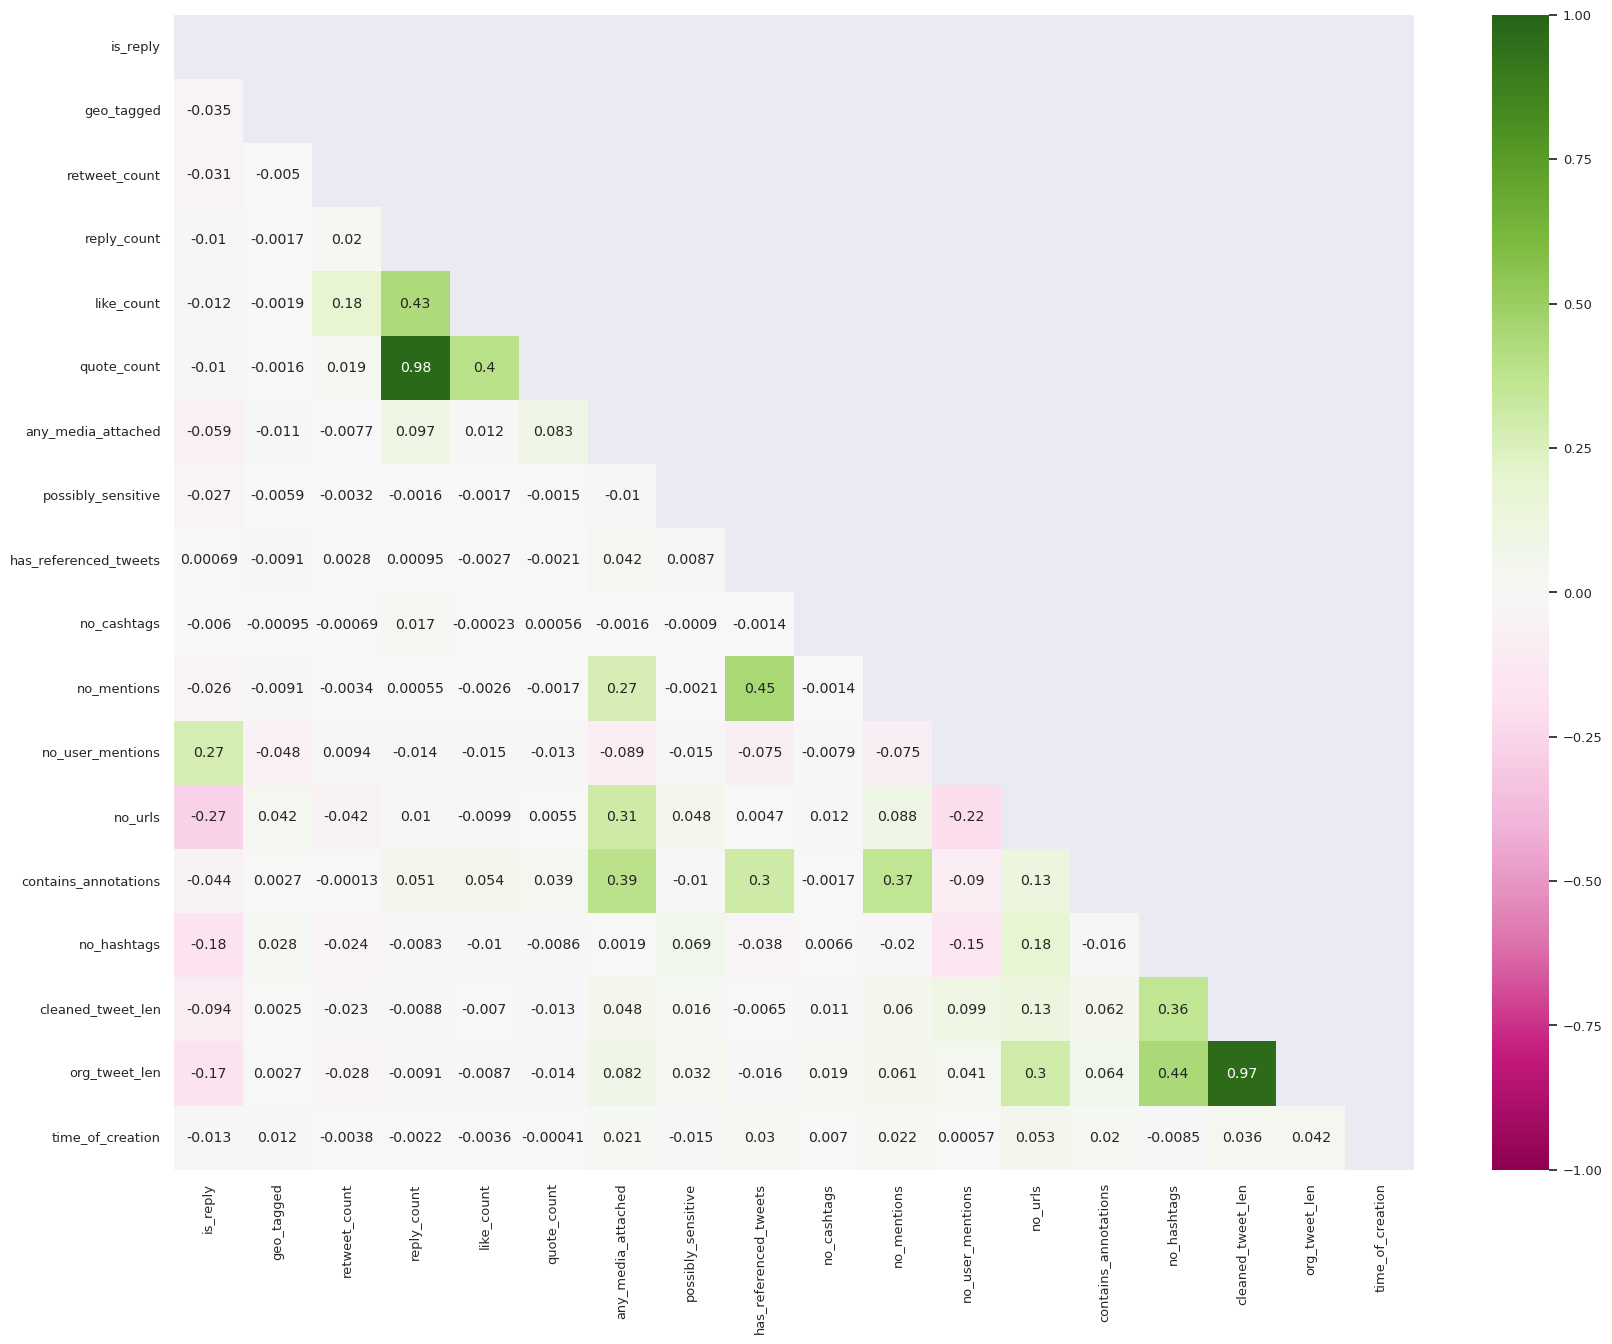

In [952]:
corr_threshold = 0.52
corr = train_tweets_data[columns_to_standardize_f].corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_tweets_data[columns_to_standardize_f]:
    for col in train_tweets_data[columns_to_standardize_f]:
        if abs(lower_tri[column][col]) > corr_threshold:
            high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [953]:
sns.set(font_scale=1)

In [954]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 2


[('reply_count', 'quote_count', 0.9785272545370034),
 ('cleaned_tweet_len', 'org_tweet_len', 0.96588820847133)]

In [955]:
train_tweets_data = train_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [956]:
val_tweets_data = val_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [957]:
test_tweets_data = test_tweets_data.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

## Correlation of numeric tweets data (without outliers)

In [958]:
sns.set(font_scale=0.95)

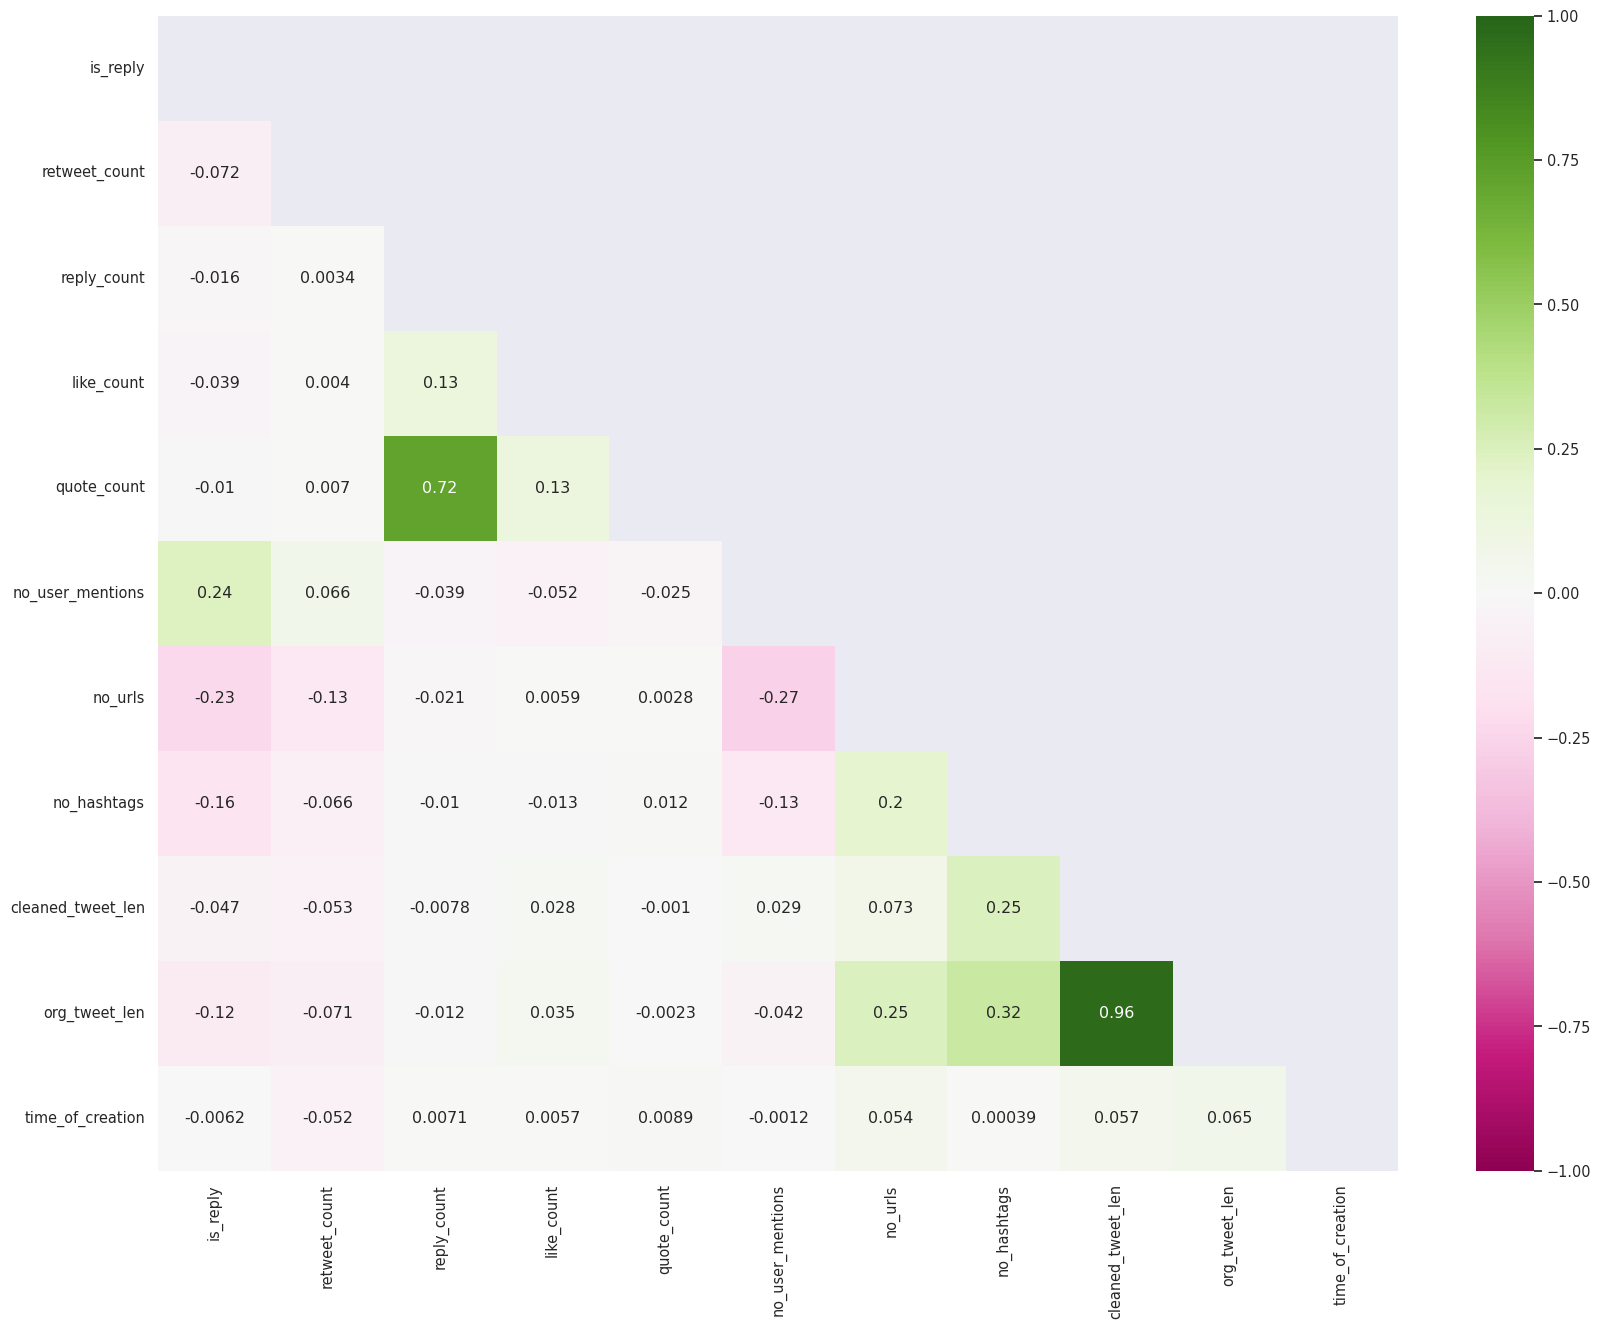

In [959]:
corr_threshold = 0.52
corr = train_tweets_data_wo_outliers[columns_to_standardize_wo_f].corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(20, 15))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_tweets_data_wo_outliers[columns_to_standardize_wo_f]:
    for col in train_tweets_data_wo_outliers[columns_to_standardize_wo_f]:
        if abs(lower_tri[column][col]) > corr_threshold:
            high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [960]:
sns.set(font_scale=1)

In [961]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 2


[('cleaned_tweet_len', 'org_tweet_len', 0.9648990986646797),
 ('reply_count', 'quote_count', 0.7164450427284585)]

In [962]:
train_tweets_data_wo_outliers = train_tweets_data_wo_outliers.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [963]:
val_tweets_data_wo_outliers = val_tweets_data_wo_outliers.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

In [964]:
test_tweets_data_wo_outliers = test_tweets_data_wo_outliers.drop(['cleaned_tweet_len', 'quote_count'], axis=1)

## Split tweets data for input and output

#### And convert inputs to tensors

In [965]:
train_tweets_add_feat_data_X = tf.convert_to_tensor(train_tweets_data.drop(['id', 'author_label', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
train_tweets_text_data_X = tf.convert_to_tensor(train_tweets_data['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
train_tweets_data_Y = pd.concat([train_tweets_data['author_label']], axis=1)

val_tweets_add_feat_data_X = tf.convert_to_tensor(val_tweets_data.drop(['id', 'author_label', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
val_tweets_text_data_X= tf.convert_to_tensor(val_tweets_data['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
val_tweets_data_Y = pd.concat([val_tweets_data['author_label']], axis=1)

test_tweets_add_feat_data_X = tf.convert_to_tensor(test_tweets_data.drop(['id', 'author_label', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
test_tweets_text_data_X = tf.convert_to_tensor(test_tweets_data['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
test_tweets_data_Y = pd.concat([test_tweets_data['author_label']], axis=1)

(without outliers):

In [966]:
train_tweets_add_feat_data_wo_X = tf.convert_to_tensor(train_tweets_data_wo_outliers.drop(['id', 'author_label', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
train_tweets_text_data_wo_X = tf.convert_to_tensor(train_tweets_data_wo_outliers['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
train_tweets_dta_wo_Y = pd.concat([train_tweets_data_wo_outliers['author_label']], axis=1)

val_tweets_add_feat_data_wo_X = tf.convert_to_tensor(val_tweets_data_wo_outliers.drop(['id', 'author_label', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
val_tweets_text_data_wo_X= tf.convert_to_tensor(val_tweets_data_wo_outliers['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
val_tweets_data_wo_Y = pd.concat([val_tweets_data_wo_outliers['author_label']], axis=1)

test_tweets_add_feat_data_wo_X = tf.convert_to_tensor(test_tweets_data_wo_outliers.drop(['id', 'author_label', 'text', 'text_np', 'text_tk', 'text_seq', 'text_seq_ps'], axis=1).values, dtype=tf.float32)
test_tweets_text_data_wo_X = tf.convert_to_tensor(test_tweets_data_wo_outliers['text_seq_ps'].apply(lambda x: x[0]).tolist(), dtype=tf.float32)
test_tweets_data_wo_Y = pd.concat([test_tweets_data_wo_outliers['author_label']], axis=1)

------
------

# DNN models

#### Function to load a saved neural network model

In [967]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [968]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [969]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [970]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, concatenate

In [971]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [972]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs, patience=50):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(metric='val_accuracy', mode = 'max', patience=patience),
                           checkpoint_callback(model_name)])
    return model

In [973]:
def prediction_and_metrics(model, test_X, test_Y):
    out_Y_org = model.predict(test_X, verbose=0)
    out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

    x = range(0, len(test_Y))
    fig = plt.figure(figsize=(18, 4))
    colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
    plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
    plt.plot(x, [0.5] * len(test_Y), c='orange')
    plt.ylim((0,1))

    create_confusion_matrix(test_Y, out_Y)
    get_model_metrics(test_Y, out_Y)

## Model 1.

#### Create model

In [991]:
def create_model_1(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(9,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # Text input
    text_input = Input(shape=(max_sequence_length,))
    # Embedding layer for text
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # LSTM layer
    lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    
    # Concatenate text and additional features
    concatenated = concatenate([lstm_layer, additional_tweet_input])
    
    dense_layer1 = Dense(128)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    output_layer = Dense(1, activation='sigmoid')(activation_layer1)
    
    model = Model(inputs=[text_input, additional_tweet_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

### batch_size=50, epochs=200

#### Create and train model

In [992]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_50_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_1(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


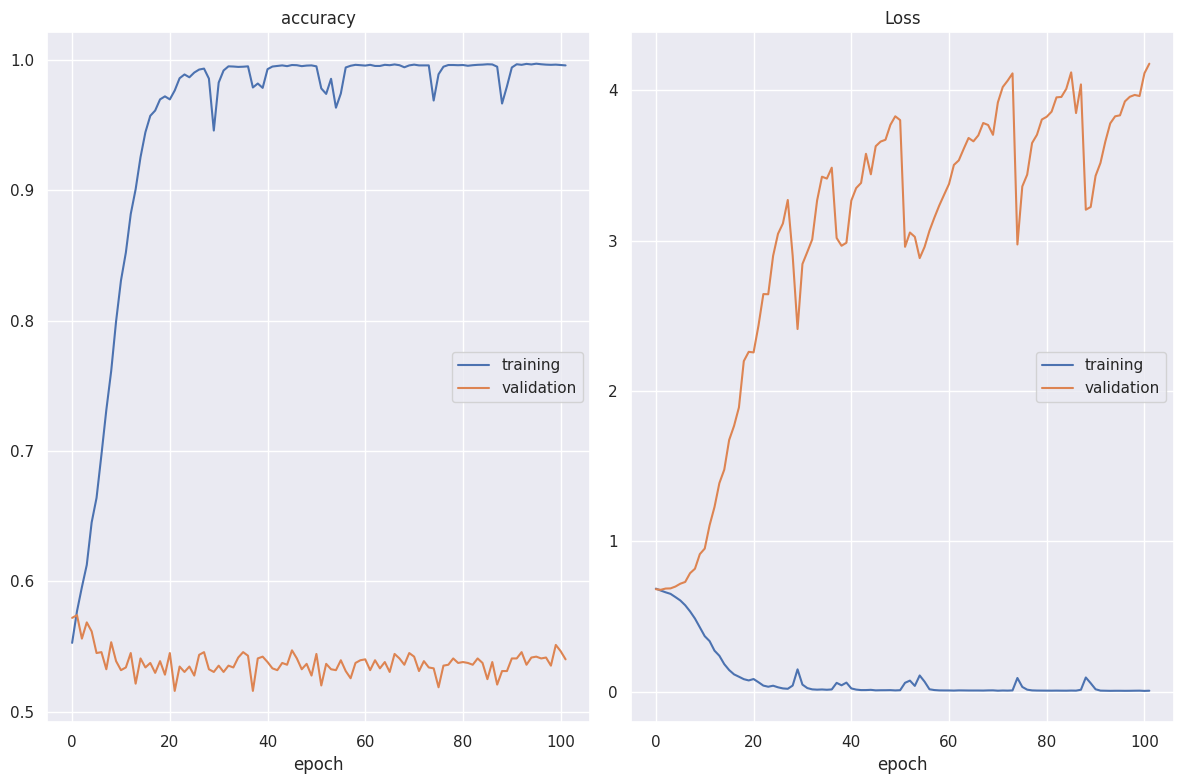

accuracy
	training         	 (min:    0.553, max:    0.997, cur:    0.996)
	validation       	 (min:    0.516, max:    0.574, cur:    0.540)
Loss
	training         	 (min:    0.006, max:    0.686, cur:    0.008)
	validation       	 (min:    0.678, max:    4.176, cur:    4.176)

Epoch 102: val_accuracy did not improve from 0.57400
139/139 [==============================] - 3s 21ms/step - loss: 0.0076 - accuracy: 0.9958 - val_loss: 4.1755 - val_accuracy: 0.5401


In [993]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=50, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5817307692307693
Precision: [0.58463727 0.57901726]
Recall: 0.5989010989010989
F1 score: 0.588791
ROC AUC: 0.581731


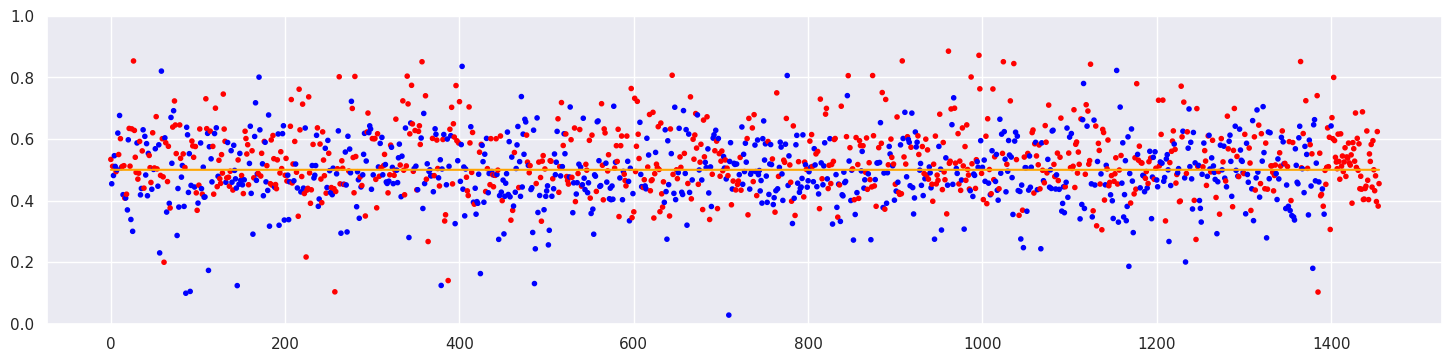

<Figure size 640x480 with 0 Axes>

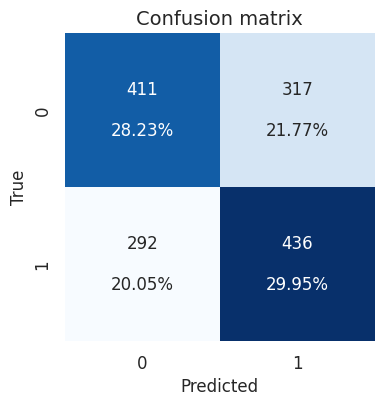

In [994]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

### batch_size=100, epochs=200

#### Create and train model

In [995]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_100_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_1(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


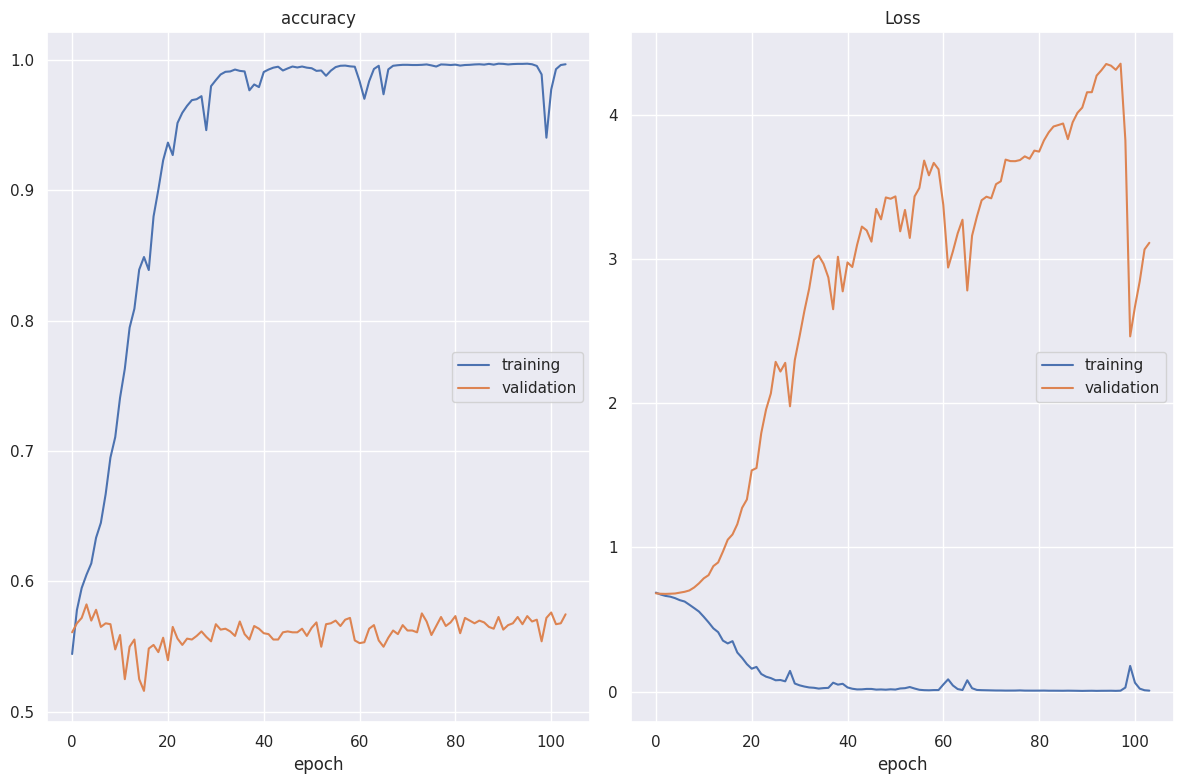

accuracy
	training         	 (min:    0.544, max:    0.997, cur:    0.997)
	validation       	 (min:    0.516, max:    0.582, cur:    0.575)
Loss
	training         	 (min:    0.006, max:    0.687, cur:    0.008)
	validation       	 (min:    0.678, max:    4.352, cur:    3.111)

Epoch 104: val_accuracy did not improve from 0.58230
70/70 [==============================] - 2s 31ms/step - loss: 0.0081 - accuracy: 0.9968 - val_loss: 3.1111 - val_accuracy: 0.5747


In [996]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=100, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5673076923076923
Precision: [0.55432373 0.58844765]
Recall: 0.4478021978021978
F1 score: 0.508580
ROC AUC: 0.567308


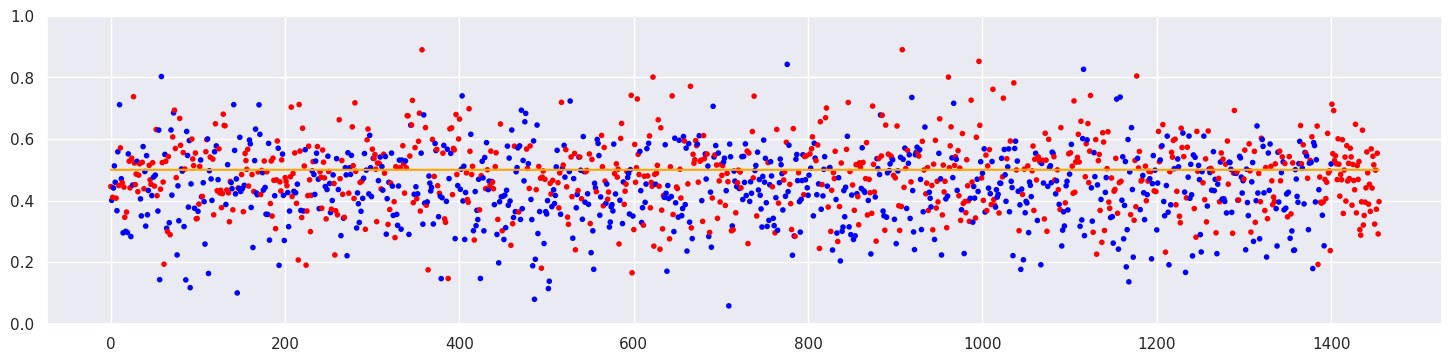

<Figure size 640x480 with 0 Axes>

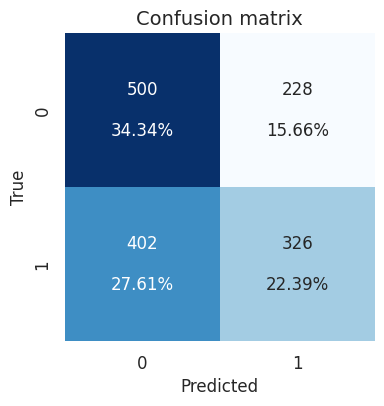

In [997]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

### batch_size=200, epochs=200

#### Create and train model

In [998]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_200_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_1(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


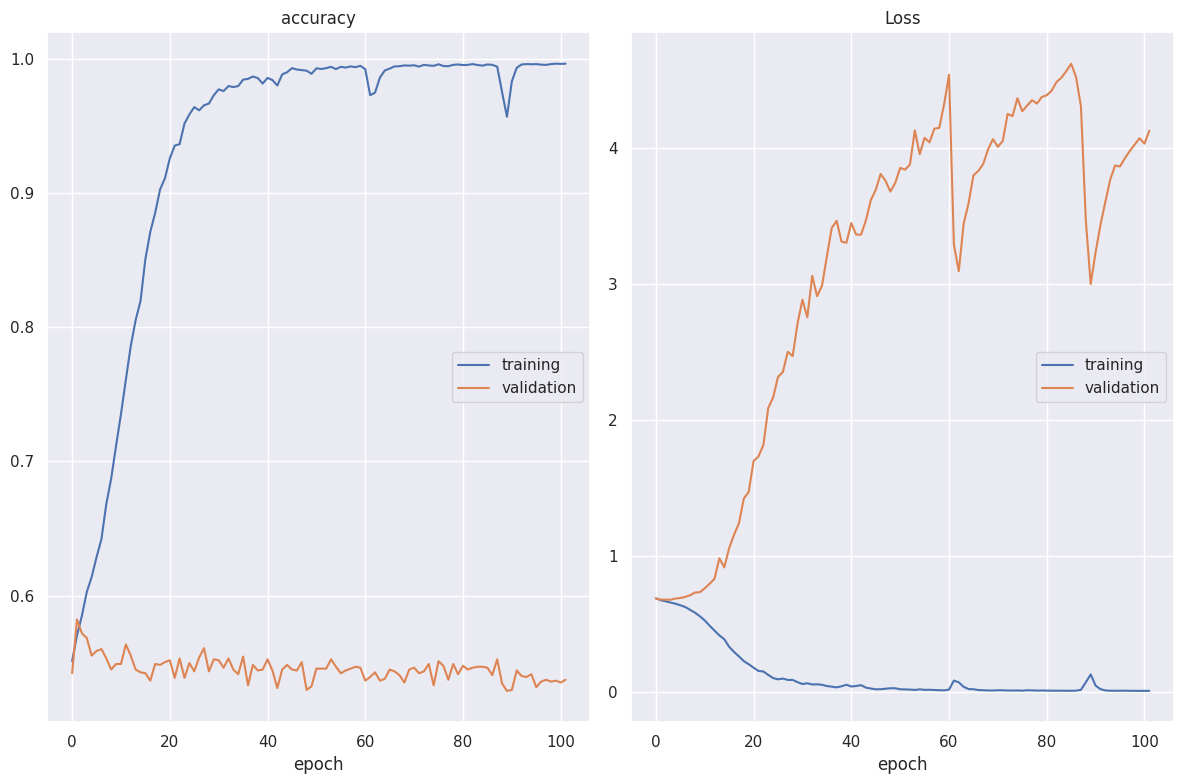

accuracy
	training         	 (min:    0.551, max:    0.996, cur:    0.996)
	validation       	 (min:    0.529, max:    0.582, cur:    0.537)
Loss
	training         	 (min:    0.009, max:    0.689, cur:    0.009)
	validation       	 (min:    0.679, max:    4.623, cur:    4.130)

Epoch 102: val_accuracy did not improve from 0.58230
35/35 [==============================] - 2s 47ms/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 4.1300 - val_accuracy: 0.5373


In [999]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=200, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5679945054945055
Precision: [0.55709343 0.58404075]
Recall: 0.4725274725274725
F1 score: 0.522399
ROC AUC: 0.567995


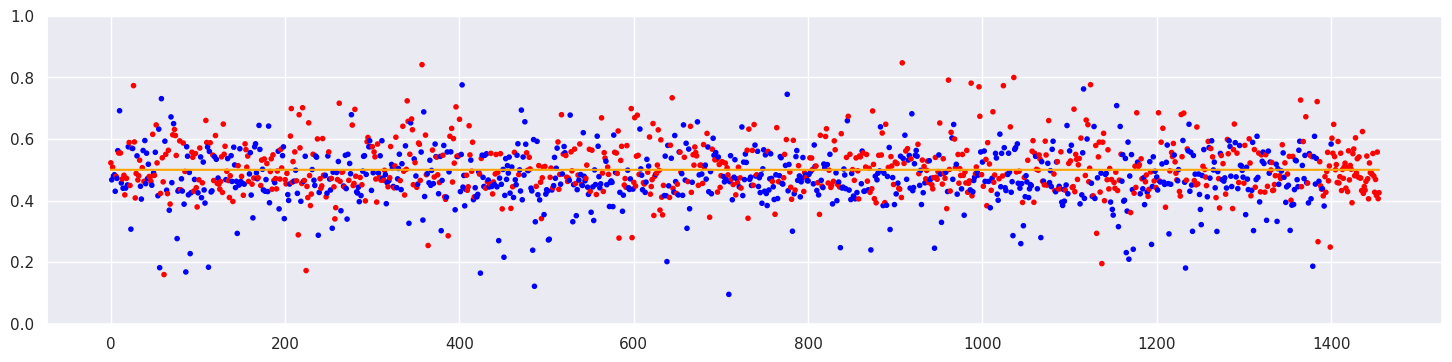

<Figure size 640x480 with 0 Axes>

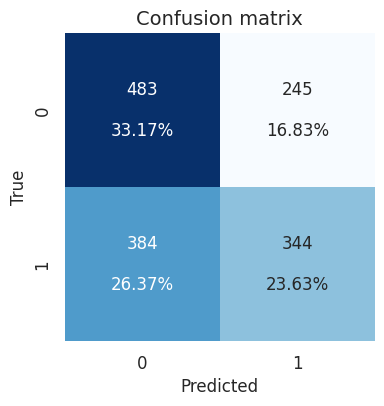

In [1000]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

#### Prediction on training subset 

Accuracy: 0.586
Precision: [0.56152927 0.61689291]
Recall: 0.5270618556701031
F1 score: 0.568450
ROC AUC: 0.588117


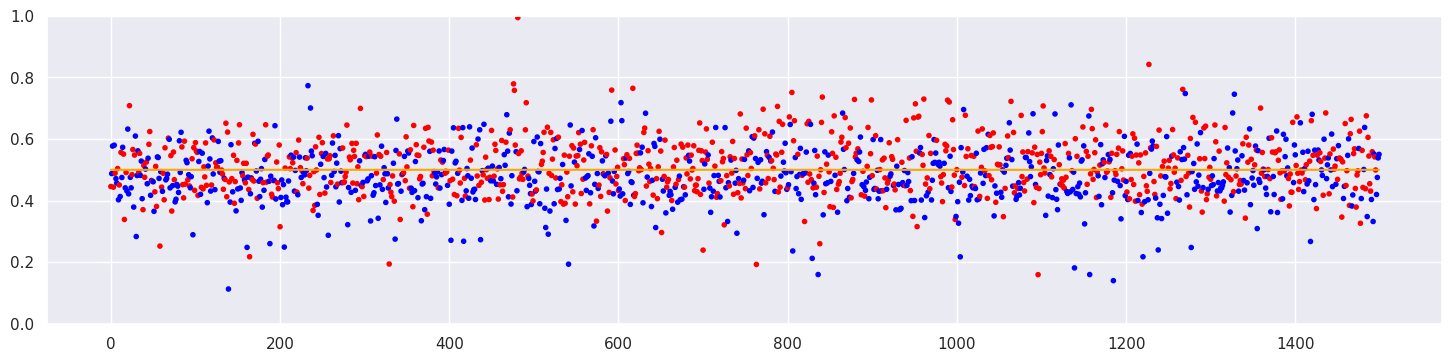

<Figure size 640x480 with 0 Axes>

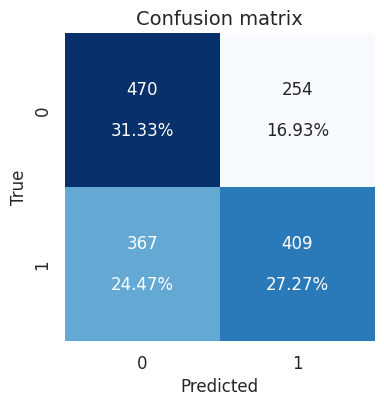

In [1001]:
prediction_and_metrics(model, [train_tweets_text_data_X[:1500], train_tweets_add_feat_data_X[:1500]], train_tweets_data_Y[:1500])

### batch_size=300, epochs=200

#### Create and train model

In [1002]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_300_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_1(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


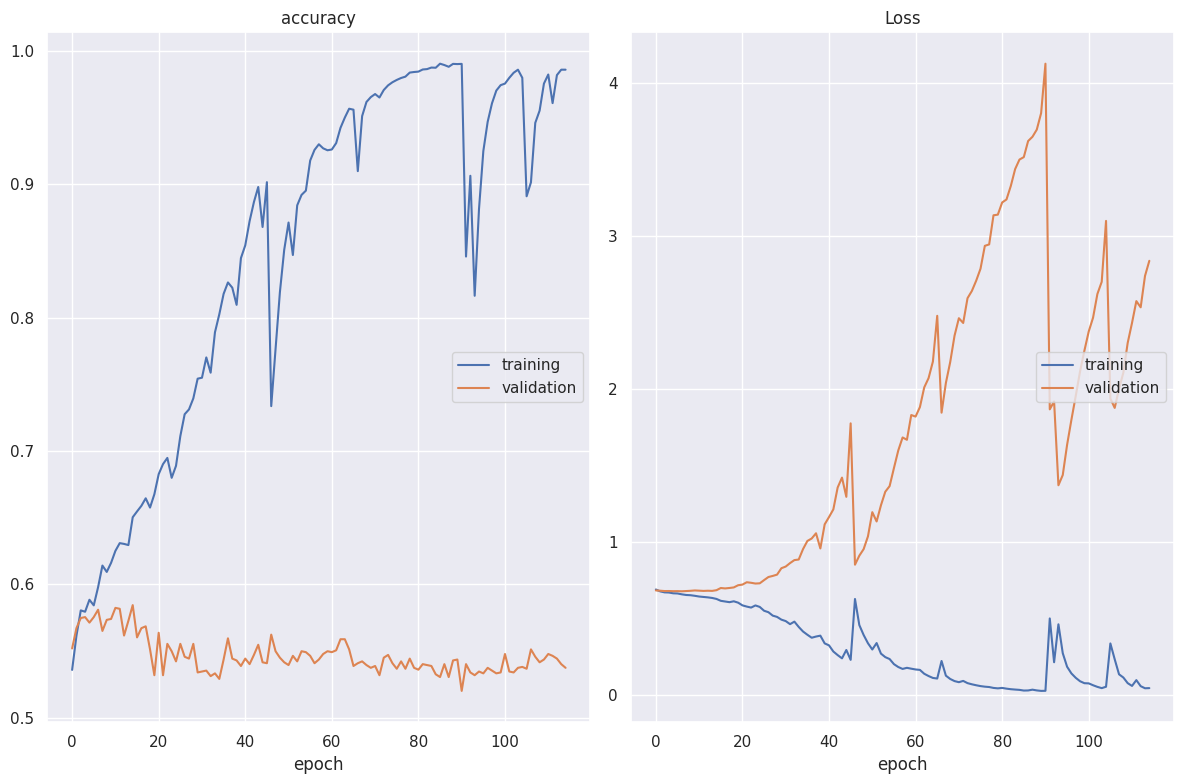

accuracy
	training         	 (min:    0.536, max:    0.990, cur:    0.986)
	validation       	 (min:    0.520, max:    0.584, cur:    0.537)
Loss
	training         	 (min:    0.028, max:    0.691, cur:    0.046)
	validation       	 (min:    0.679, max:    4.128, cur:    2.839)

Epoch 115: val_accuracy did not improve from 0.58437
24/24 [==============================] - 1s 61ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 2.8393 - val_accuracy: 0.5373


In [1003]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=300, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5982142857142857
Precision: [0.5988935  0.59754434]
Recall: 0.6016483516483516
F1 score: 0.599589
ROC AUC: 0.598214


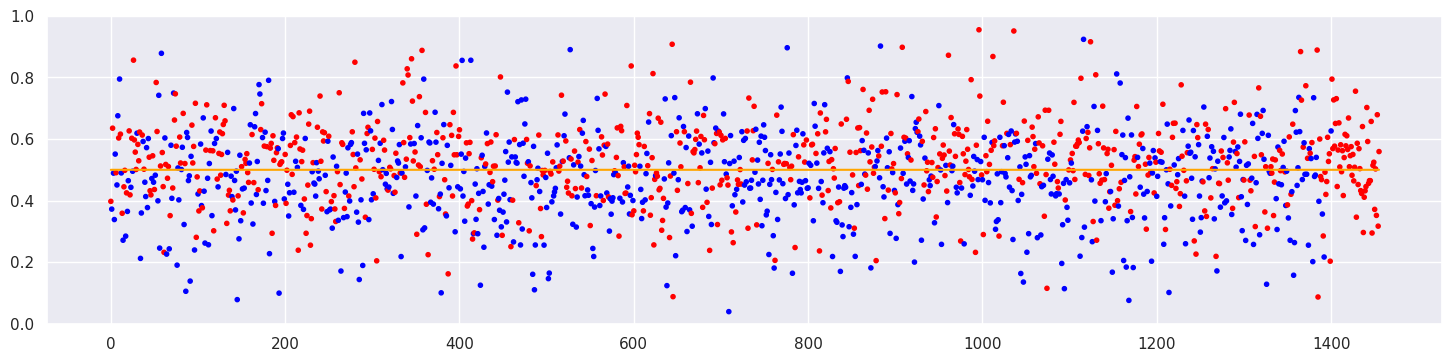

<Figure size 640x480 with 0 Axes>

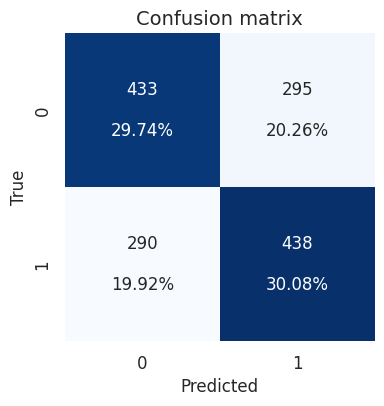

In [1004]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

### batch_size=500, epochs=200

#### Create and train model

In [1005]:
model_name = 'model_tweets_data_based_10000_1_v1_batch_size_500_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_1(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


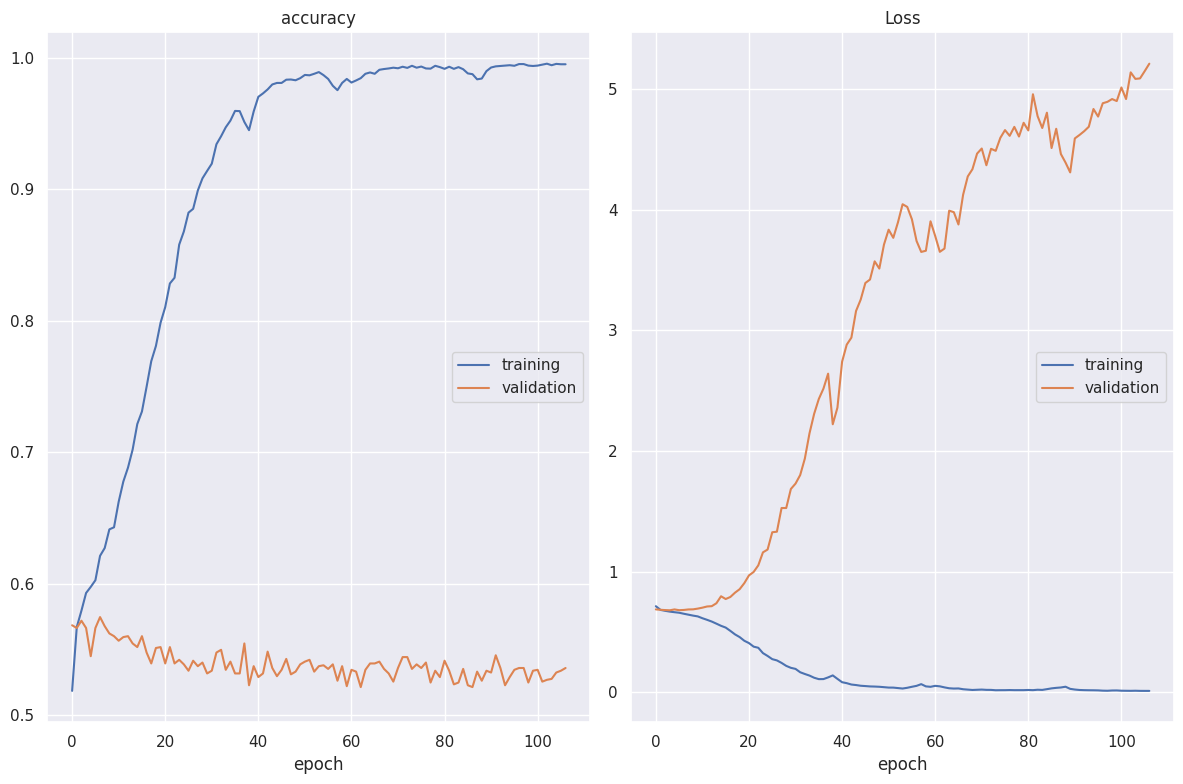

accuracy
	training         	 (min:    0.519, max:    0.996, cur:    0.995)
	validation       	 (min:    0.521, max:    0.575, cur:    0.536)
Loss
	training         	 (min:    0.011, max:    0.713, cur:    0.011)
	validation       	 (min:    0.679, max:    5.209, cur:    5.209)

Epoch 107: val_accuracy did not improve from 0.57469
14/14 [==============================] - 1s 90ms/step - loss: 0.0109 - accuracy: 0.9952 - val_loss: 5.2092 - val_accuracy: 0.5360


In [1006]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=500, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5748626373626373
Precision: [0.57105606 0.57910015]
Recall: 0.5480769230769231
F1 score: 0.563162
ROC AUC: 0.574863


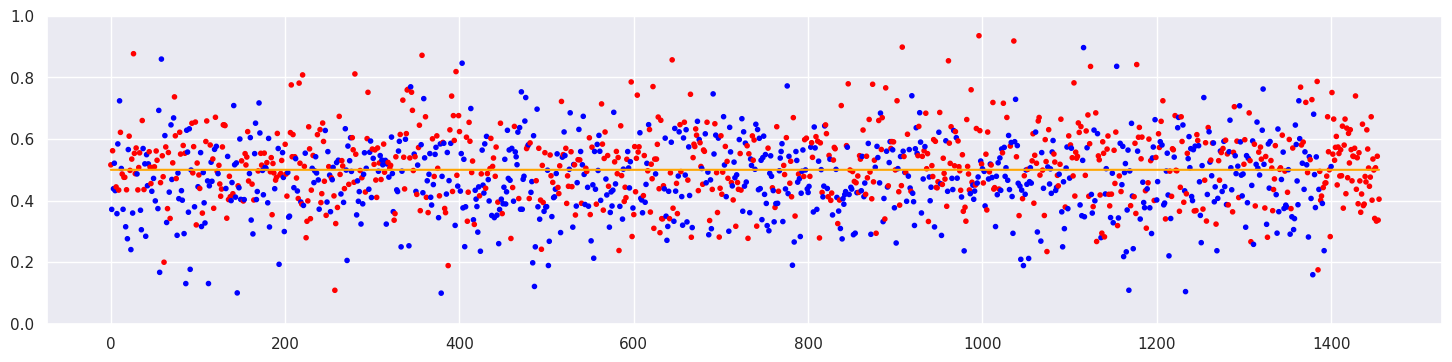

<Figure size 640x480 with 0 Axes>

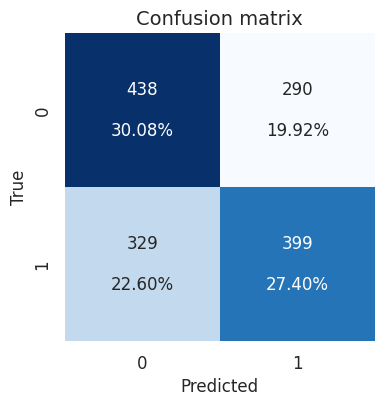

In [1007]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

## Model 2.

#### Create model

In [1008]:
def create_model_2(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(9,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # Text input
    text_input = Input(shape=(max_sequence_length,))
    # Embedding layer for text
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # LSTM layer
    lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    
    # Concatenate text and additional features
    concatenated = concatenate([lstm_layer, additional_tweet_input])
    
    dense_layer1 = Dense(128)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.5)(dense_layer1)
    dense_layer2 = Dense(64)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    model = Model(inputs=[text_input, additional_tweet_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

### batch_size=50, epochs=200

#### Create and train model

In [1009]:
model_name = 'model_tweets_data_based_10000_2_v1_batch_size_50_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


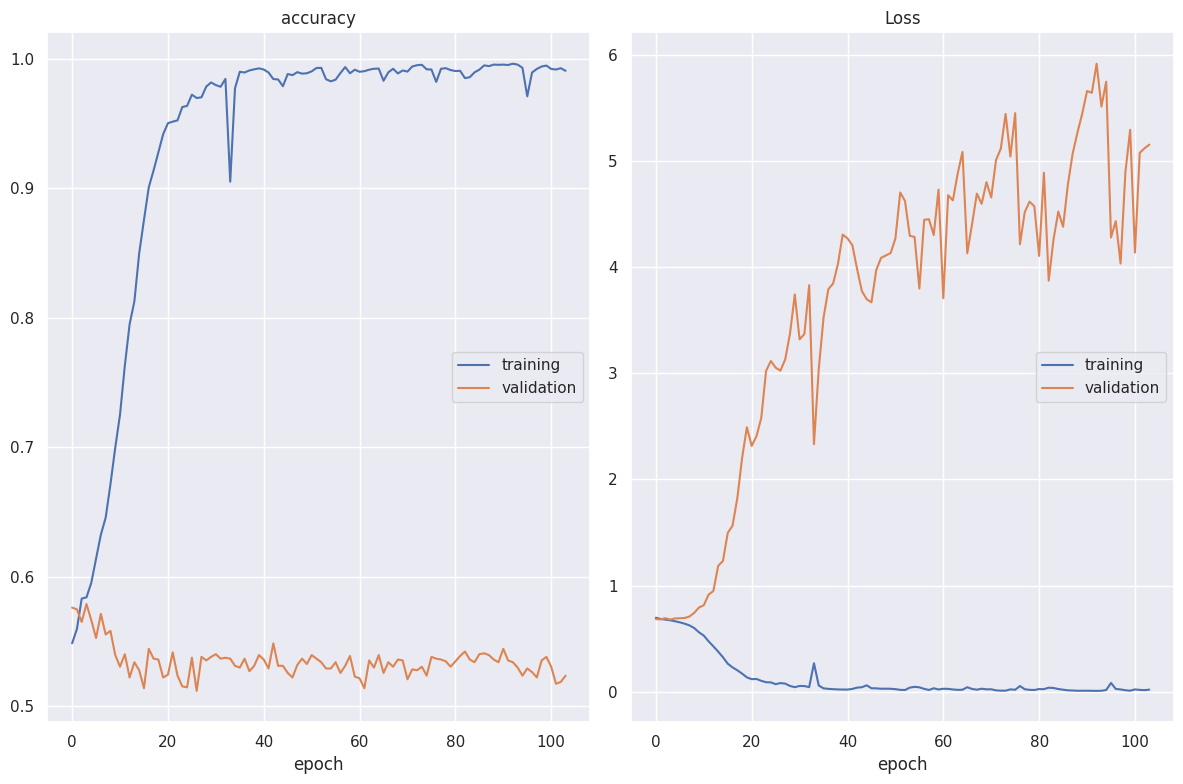

accuracy
	training         	 (min:    0.549, max:    0.996, cur:    0.991)
	validation       	 (min:    0.512, max:    0.579, cur:    0.524)
Loss
	training         	 (min:    0.009, max:    0.698, cur:    0.021)
	validation       	 (min:    0.681, max:    5.915, cur:    5.153)

Epoch 104: val_accuracy did not improve from 0.57884
139/139 [==============================] - 3s 20ms/step - loss: 0.0207 - accuracy: 0.9906 - val_loss: 5.1530 - val_accuracy: 0.5235


In [1010]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=50, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5831043956043956
Precision: [0.57726692 0.58989599]
Recall: 0.5453296703296703
F1 score: 0.566738
ROC AUC: 0.583104


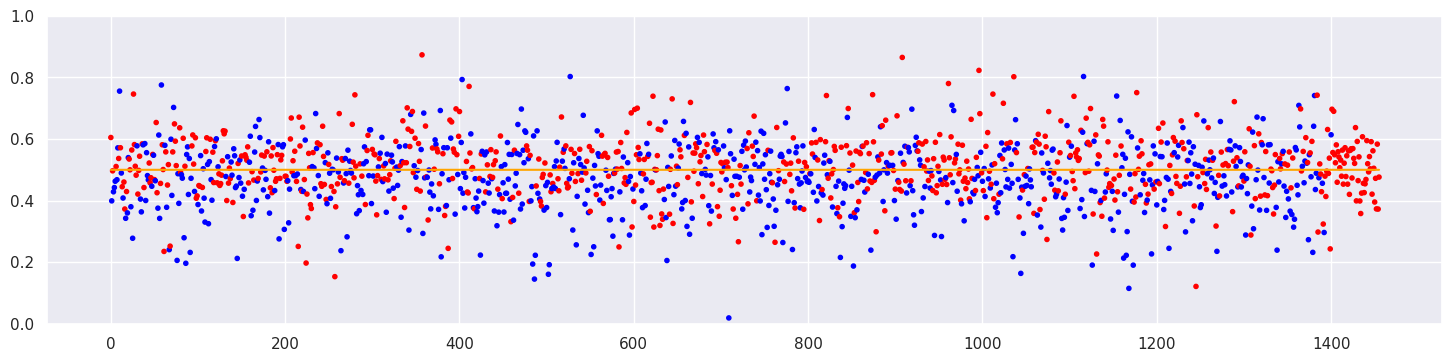

<Figure size 640x480 with 0 Axes>

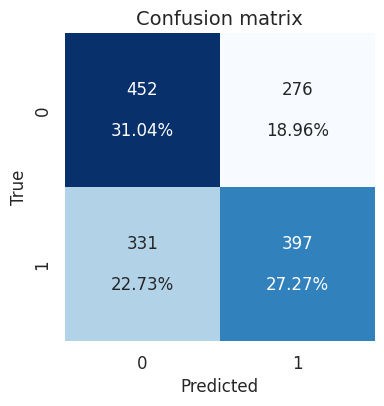

In [1011]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

### batch_size=100, epochs=200

#### Create and train model

In [1012]:
model_name = 'model_tweets_data_based_10000_2_v1_batch_size_100_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


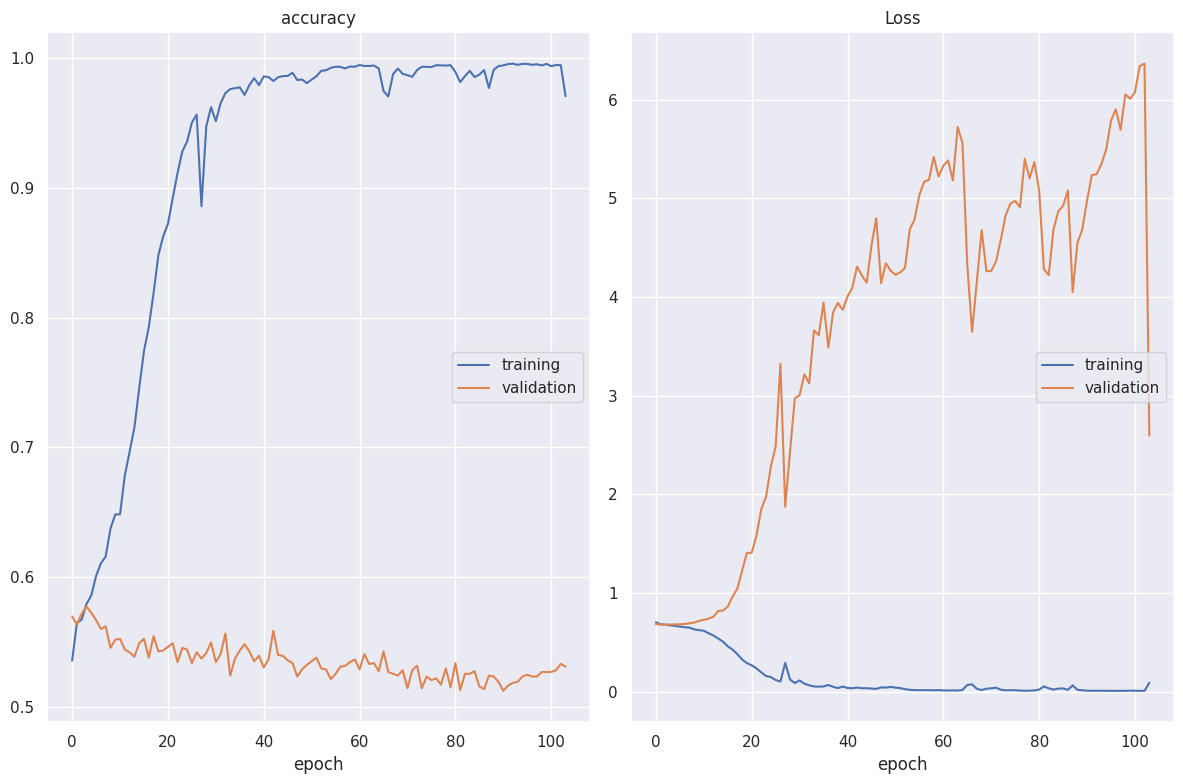

accuracy
	training         	 (min:    0.536, max:    0.996, cur:    0.971)
	validation       	 (min:    0.512, max:    0.577, cur:    0.531)
Loss
	training         	 (min:    0.010, max:    0.705, cur:    0.093)
	validation       	 (min:    0.680, max:    6.365, cur:    2.595)

Epoch 104: val_accuracy did not improve from 0.57746
70/70 [==============================] - 2s 31ms/step - loss: 0.0925 - accuracy: 0.9706 - val_loss: 2.5951 - val_accuracy: 0.5311


In [1013]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=100, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5741758241758241
Precision: [0.5675     0.58231707]
Recall: 0.5247252747252747
F1 score: 0.552023
ROC AUC: 0.574176


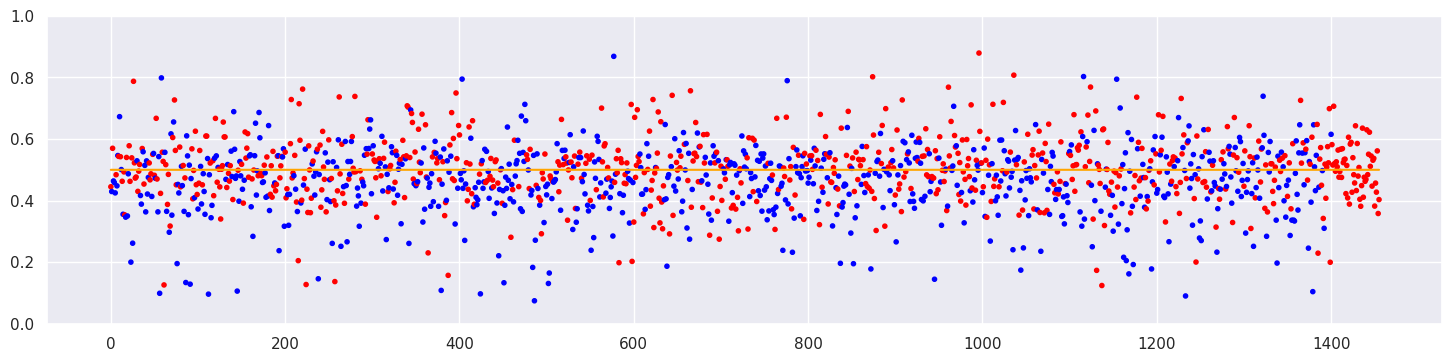

<Figure size 640x480 with 0 Axes>

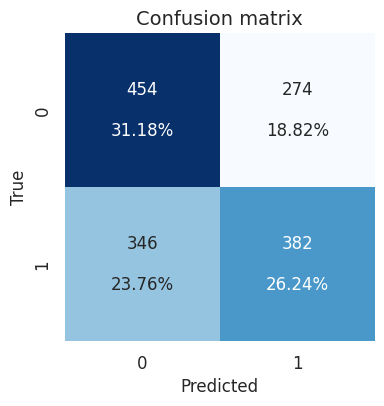

In [1014]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

### batch_size=200, epochs=200

#### Create and train model

In [1017]:
model_name = 'model_tweets_data_based_10000_2_v1_batch_size_200_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


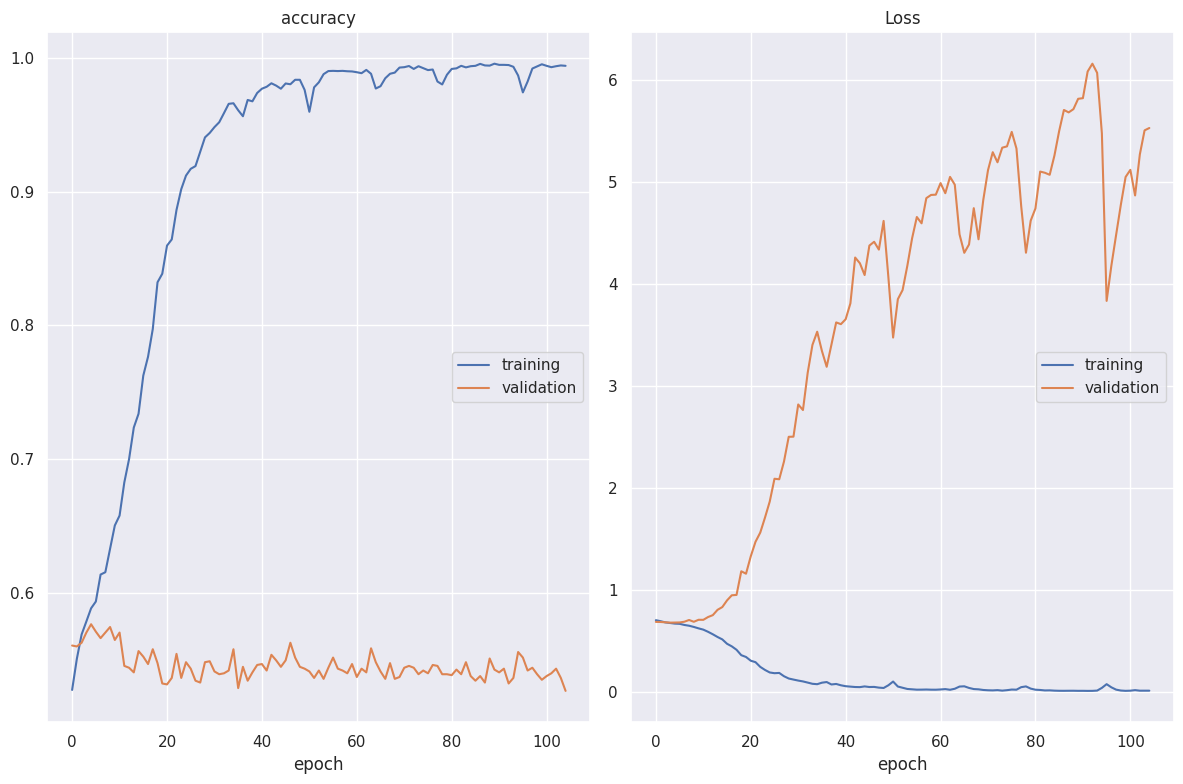

accuracy
	training         	 (min:    0.528, max:    0.996, cur:    0.994)
	validation       	 (min:    0.527, max:    0.577, cur:    0.527)
Loss
	training         	 (min:    0.011, max:    0.704, cur:    0.013)
	validation       	 (min:    0.680, max:    6.159, cur:    5.529)

Epoch 105: val_accuracy did not improve from 0.57676
35/35 [==============================] - 2s 52ms/step - loss: 0.0132 - accuracy: 0.9939 - val_loss: 5.5289 - val_accuracy: 0.5270


In [1018]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=200, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.570054945054945
Precision: [0.55821918 0.58793103]
Recall: 0.4684065934065934
F1 score: 0.521407
ROC AUC: 0.570055


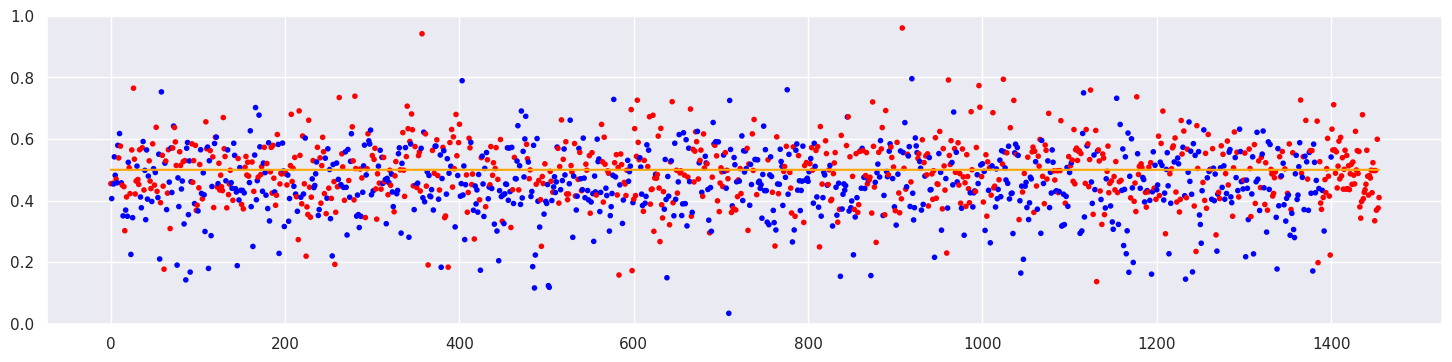

<Figure size 640x480 with 0 Axes>

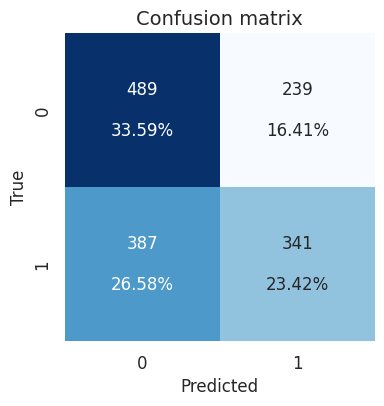

In [1019]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

#### Prediction on training subset 

Accuracy: 0.5993333333333334
Precision: [0.56949153 0.64227642]
Recall: 0.509020618556701
F1 score: 0.567937
ROC AUC: 0.602577


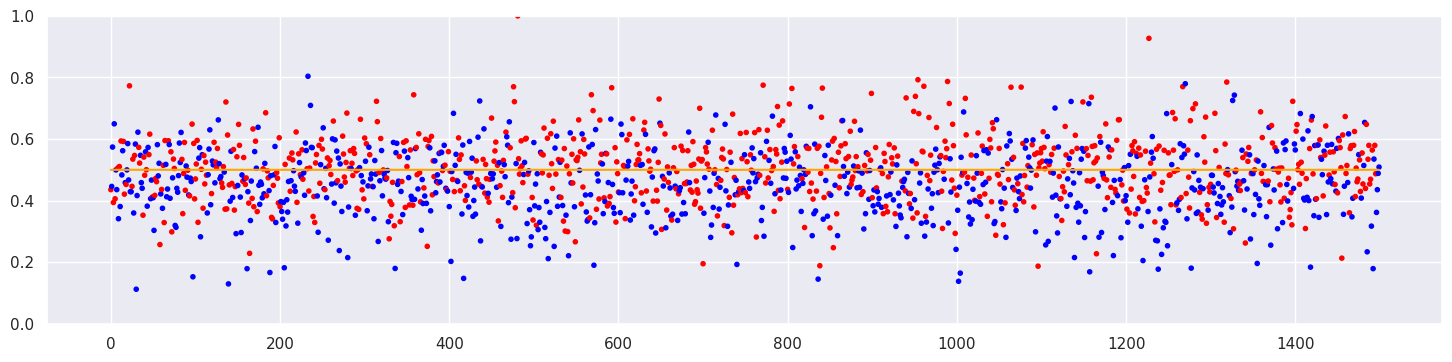

<Figure size 640x480 with 0 Axes>

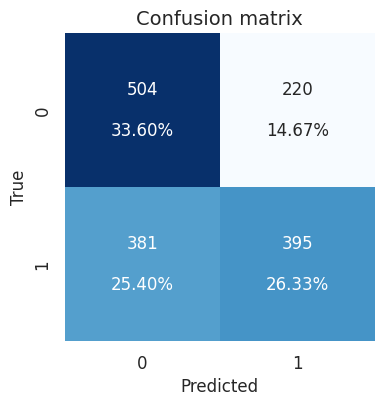

In [1020]:
prediction_and_metrics(model, [train_tweets_text_data_X[:1500], train_tweets_add_feat_data_X[:1500]], train_tweets_data_Y[:1500])

### batch_size=300, epochs=200

#### Create and train model

In [1021]:
model_name = 'model_tweets_data_based_10000_2_v1_batch_size_300_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


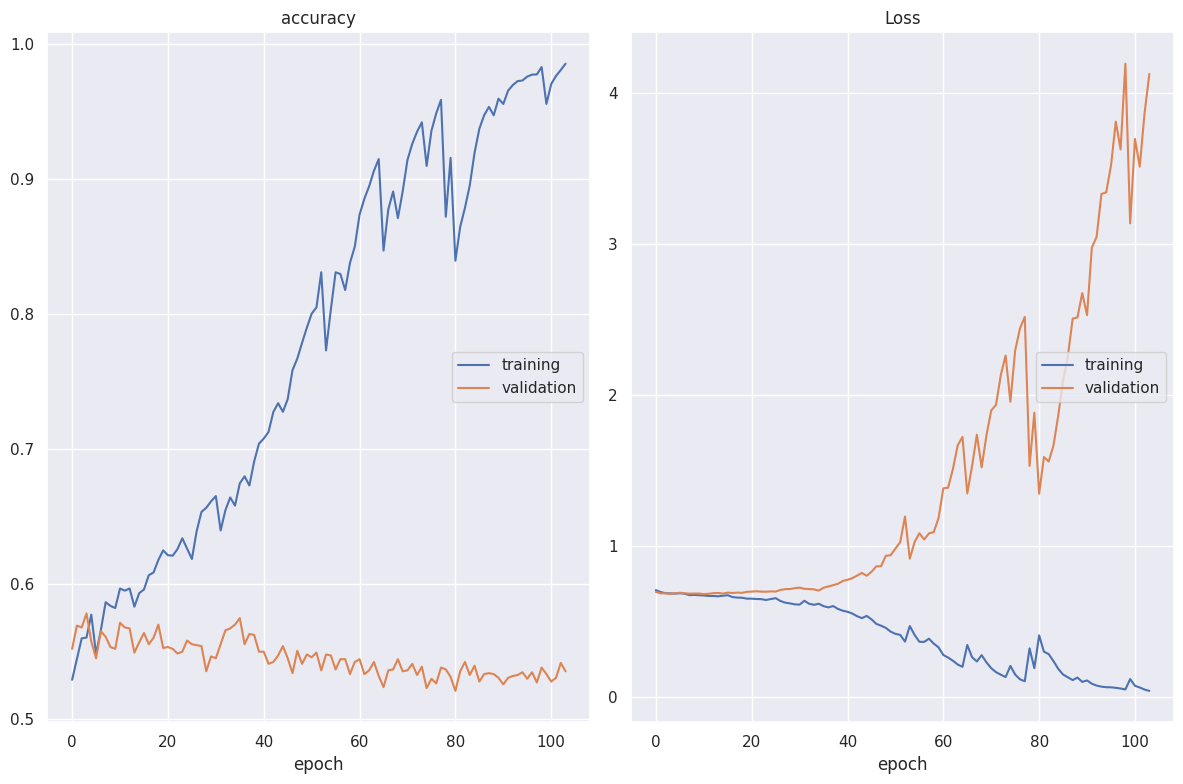

accuracy
	training         	 (min:    0.529, max:    0.986, cur:    0.986)
	validation       	 (min:    0.521, max:    0.578, cur:    0.535)
Loss
	training         	 (min:    0.037, max:    0.705, cur:    0.037)
	validation       	 (min:    0.679, max:    4.195, cur:    4.127)

Epoch 104: val_accuracy did not improve from 0.57815
24/24 [==============================] - 1s 62ms/step - loss: 0.0372 - accuracy: 0.9857 - val_loss: 4.1265 - val_accuracy: 0.5353


In [ ]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=300, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5748626373626373
Precision: [0.56720099 0.58449612]
Recall: 0.5178571428571429
F1 score: 0.549162
ROC AUC: 0.574863


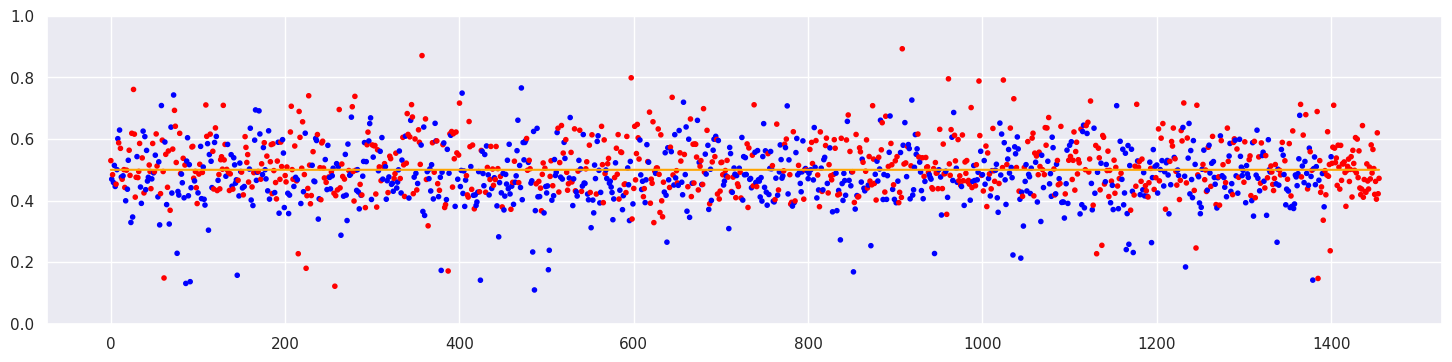

<Figure size 640x480 with 0 Axes>

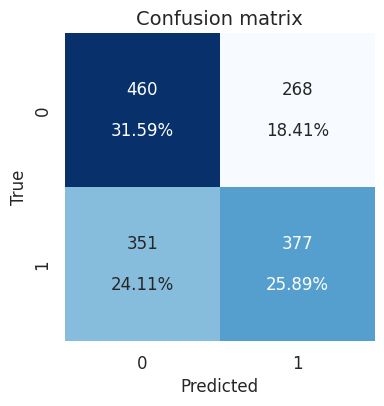

In [ ]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

### batch_size=500, epochs=200

#### Create and train model

In [ ]:
model_name = 'model_tweets_data_based_10000_2_v1_batch_size_500_single_tweet_glove_embed_max_len_15'
tweets_numeric_subset_size = train_tweets_add_feat_data_X.shape[1]

model = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


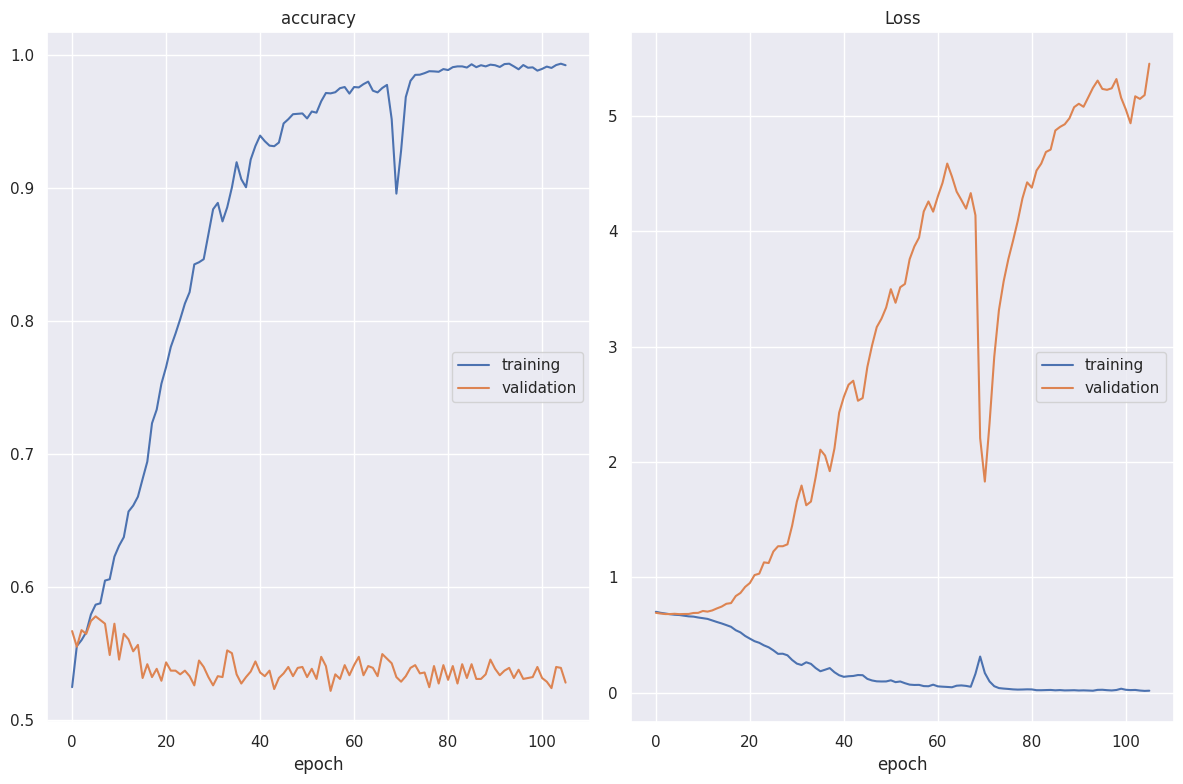

accuracy
	training         	 (min:    0.525, max:    0.993, cur:    0.992)
	validation       	 (min:    0.522, max:    0.578, cur:    0.528)
Loss
	training         	 (min:    0.016, max:    0.702, cur:    0.018)
	validation       	 (min:    0.681, max:    5.451, cur:    5.451)

Epoch 106: val_accuracy did not improve from 0.57815
14/14 [==============================] - 1s 93ms/step - loss: 0.0176 - accuracy: 0.9923 - val_loss: 5.4511 - val_accuracy: 0.5284


In [1025]:
model =  train_model(model, 
                      model_name, 
                      train_X=[train_tweets_text_data_X, train_tweets_add_feat_data_X], 
                      train_Y=train_tweets_data_Y,
                      val_X=[val_tweets_text_data_X, val_tweets_add_feat_data_X], 
                      val_Y=val_tweets_data_Y,
                      batch_size=500, 
                      epochs=200,
                      patience=100)

#### Prediction and results

Accuracy: 0.5865384615384616
Precision: [0.57974684 0.59459459]
Recall: 0.5439560439560439
F1 score: 0.568149
ROC AUC: 0.586538


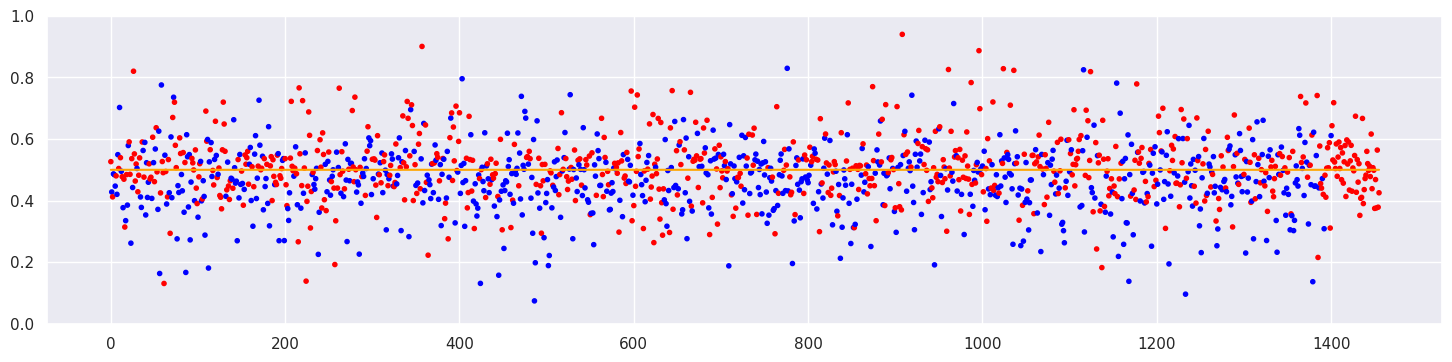

<Figure size 640x480 with 0 Axes>

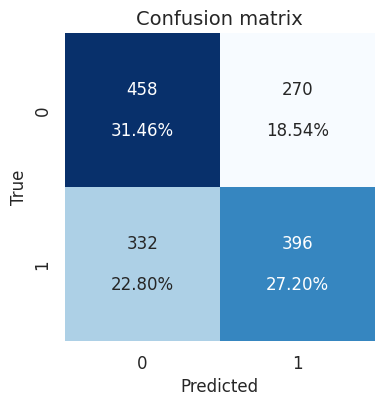

In [1026]:
prediction_and_metrics(model, [test_tweets_text_data_X, test_tweets_add_feat_data_X], test_tweets_data_Y)

## Model 3.

#### Create and train model

In [ ]:
def create_model_3(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(18,), add_user_feat_size=(6,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # # Text input
    # text_input = Input(shape=(max_sequence_length,))
    # # Embedding layer for text
    # embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # # LSTM layer
    # lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    # Additional user's features input
    additional_user_input = Input(shape=(add_user_feat_size,)) 
    
    # Concatenate text and additional features
    # concatenated = concatenate([lstm_layer, additional_tweet_input, additional_user_input])
    concatenated = concatenate([additional_tweet_input, additional_user_input])
    
    dense_layer1 = Dense(128)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.5)(dense_layer1)
    dense_layer2 = Dense(64)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    # model = Model(inputs=[text_input, additional_tweet_input, additional_user_input], outputs=output_layer)
    model = Model(inputs=[additional_tweet_input, additional_user_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

In [ ]:
model_name = 'model_users_and_tweets_data_based_10000_2_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model2 = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


In [ ]:
model_name = 'model_users_and_tweets_data_based_10000_2_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model2 = create_model_2(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


In [ ]:
#### Prediction and results

In [ ]:
# prediction_and_metrics(model2, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)
prediction_and_metrics(model2, [test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)

In [ ]:
## Model 3.

In [ ]:
#### Create and train model

In [ ]:
def create_model_3(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(18,), add_user_feat_size=(6,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # # Text input
    # text_input = Input(shape=(max_sequence_length,))
    # # Embedding layer for text
    # embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # # LSTM layer
    # lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    # Additional user's features input
    additional_user_input = Input(shape=(add_user_feat_size,)) 
    
    # Concatenate text and additional features
    # concatenated = concatenate([lstm_layer, additional_tweet_input, additional_user_input])
    concatenated = concatenate([additional_tweet_input, additional_user_input])
    
    dense_layer1 = Dense(64)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.1)(dense_layer1)
    dense_layer2 = Dense(64)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    # model = Model(inputs=[text_input, additional_tweet_input, additional_user_input], outputs=output_layer)
    model = Model(inputs=[additional_tweet_input, additional_user_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

In [ ]:
model_name = 'model_users_and_tweets_data_based_10000_3_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model3 = create_model_3(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


In [ ]:
model3 =  train_model(model3, 
                      model_name, 
                      train_X=[train_tweets_add_feat_data_tensor, train_users_X_tensor], 
                      train_Y=train_users_Y, 
                      val_X=[val_tweets_add_feat_data_tensor, val_users_X_tensor], 
                      val_Y=val_users_Y, 
                      batch_size=512, 
                      epochs=100)

In [ ]:
#### Prediction and results

In [ ]:
# prediction_and_metrics(model2, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)
prediction_and_metrics(model3, [test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)

In [ ]:
## Model 4.

In [ ]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(metric='val_accuracy', mode = 'max', patience=200),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

In [ ]:
#### Create and train model

In [ ]:
def create_model_4(num_words, embedding_dim, embedding_matrix, max_sequence_length, trainable=False,
                  add_tweets_feat_size=(18,), add_user_feat_size=(6,), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
    
    # # Text input
    # text_input = Input(shape=(max_sequence_length,))
    # # Embedding layer for text
    # embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=trainable)(text_input)
    # # LSTM layer
    # lstm_layer = LSTM(64)(embedding_layer)
    
    # Additional tweet's features input
    additional_tweet_input = Input(shape=(add_tweets_feat_size,)) 
    # Additional user's features input
    additional_user_input = Input(shape=(add_user_feat_size,)) 
    
    # Concatenate text and additional features
    # concatenated = concatenate([lstm_layer, additional_tweet_input, additional_user_input])
    concatenated = concatenate([additional_tweet_input, additional_user_input])
    
    dense_layer1 = Dense(64)(concatenated)
    activation_layer1 = Activation('relu')(dense_layer1)
    dropout_layer1 = Dropout(0.1)(dense_layer1)
    dense_layer2 = Dense(32)(dropout_layer1)
    activation_layer2 = Activation('relu')(dense_layer2)
    output_layer = Dense(1, activation='sigmoid')(activation_layer2)
    
    # model = Model(inputs=[text_input, additional_tweet_input, additional_user_input], outputs=output_layer)
    model = Model(inputs=[additional_tweet_input, additional_user_input], outputs=output_layer)
    
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

In [ ]:
model_name = 'model_users_and_tweets_data_based_10000_4_v1_batch_size_200_user_data_and_single_tweet_glove'
tweets_numeric_subset_size = train_tweets_data[simple_num_cols].shape[1]
users_set_size = train_users_X.shape[1]

model4 = create_model_4(num_words=num_words, embedding_dim=embedding_dim, 
                       embedding_matrix=embedding_matrix, max_sequence_length=max_length, 
                       trainable=False, 
                       add_tweets_feat_size=tweets_numeric_subset_size, #dense_layer1=64, 
                       add_user_feat_size=users_set_size,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))


In [ ]:
model4 =  train_model(model4, 
                      model_name, 
                      train_X=[train_tweets_add_feat_data_tensor, train_users_X_tensor], 
                      train_Y=train_users_Y, 
                      val_X=[val_tweets_add_feat_data_tensor, val_users_X_tensor], 
                      val_Y=val_users_Y, 
                      batch_size=512, 
                      epochs=1000)

In [ ]:
#### Prediction and results

In [ ]:
# prediction_and_metrics(model2, [test_tweets_text_data_tensor, test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)
prediction_and_metrics(model4, [test_tweets_add_feat_data_tensor, test_users_X_tensor], test_users_Y)